In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [268]:
%matplotlib inline

# ЛР2. Классификация с помощью дерева принятия решений.

## Задание 1.

Для каждого из подзаданий: 

1. Постройте модель классификации на основе дерева принятия решений.
2. Подберите оптимальные гиперпараметры модели используя кросс-валидацию.
3. Визуализируйте деревья для моделей.
4. Протестируйте различные метрики оценки качества разбиения (Джини, Энтропия). 
5. Сделайте выводы о точности моделей.


### 1.1 Скоринг отказа от услуг оператора связи.

Используйте данные из файла telecom.csv для предсказания отказа от услуг связи. Столбец "churn". 
Предврительно изучите и подготовьте данные.

In [2]:
telecom_df = pd.read_csv("telecom.csv")

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
telecom_df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
categorical_columns = ["state", "international plan", "voice mail plan"]
quantiative_colums = ["account length", "area code", "number vmail messages",
                      "total day minutes", "total day calls", "total day charge",
                      "total eve minutes", "total eve calls", "total eve charge", "total night minutes",
                      "total night calls", "total night charge", "total intl minutes", "total intl calls",
                      "total intl charge", "customer service calls"]
target = "churn"

phone number we can not include

In [6]:
sorted(telecom_df.columns.drop("phone number")) == sorted(quantiative_colums + categorical_columns + [target])

True

In [7]:
columns_to_delete = []

In [8]:
telecom_df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [9]:
y = telecom_df[target].astype(int)
X = telecom_df[telecom_df.columns[~telecom_df.columns.isin([target, "phone number"])]]

In [10]:
X.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [11]:
true_label = "outflow of users/True"
false_label = "not outflow of users/False"

#### function for plots and dfs

In [12]:
def descriptive_stats(var, data=X, y=y):
    d = pd.DataFrame(index=data.describe().index, columns=np.unique(y))
    for x in np.unique(y):
        d[x] = data[var][y == x].describe()
    return d

In [13]:
def count_outliers(var, data=X, y=y):
    res = pd.DataFrame(index=['amount', 'percent'], columns=np.unique(y))
    for x in np.unique(y):
        df = data[var][y == x]
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        res[x] = [((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum(), 
                  ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum() / len(df)]
    return res

In [14]:
def histogram(var, data=X, y=y):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.distplot(data[var][y == False], color='skyblue', label=false_label)
    ax = sns.distplot(data[var][y == True], color='red', label=true_label)
    ax.legend()
    plt.show()

In [15]:
def violin_strip_plot(var, data=X, y=y):
    d = pd.concat([y, data[var]], axis=1)
    f, ax = plt.subplots(1, 2, figsize=(8, 6))
    plt.title(f"{var} vs {target}")
    sns.violinplot(x=target, y=var,
                           data=d, scale='count', inner='box', ax=ax[0])
    sns.stripplot(x=target, y=var,
                           data=d, ax=ax[1], size=2)
    plt.show()

In [16]:
def corrmat_plot(n, target=target, data=X):
    corrmat = data.corr()
    cols = corrmat.nlargest(n, target)[target].index
    hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, 
                     fmt='.2f', annot_kws={'size': 10}, 
                     yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

#### Stats for target variable

In [17]:
pd.DataFrame({
    true_label: [sum(y == 1), sum(y == 1) / len(y)],
    false_label: [sum(y == 0), sum(y == 0) / len(y)],
}, index = ['count', 'percent'])

,outflow of users/True,not outflow of users/False
count,483.000000,2850.000000
percent,0.144914,0.855086


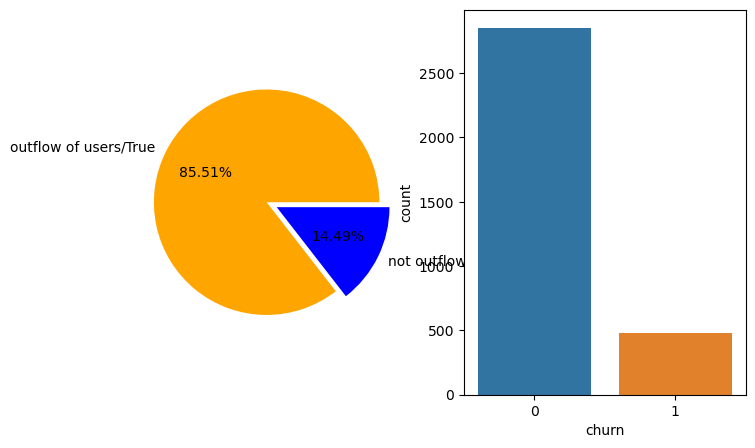

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

y.value_counts().plot.pie(explode=[0, 0.1], 
                           autopct='%1.2f%%', ax=ax[0], 
                           labels=[true_label, false_label],
                           colors=['orange', 'blue'])
ax[0].set_ylabel('')
sns.countplot(target, data=pd.DataFrame(y.replace({False: false_label, True: true_label})), ax=ax[1])
plt.show()

#### Quantitative stats

In [19]:
X[quantiative_colums].describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


#### Categorical stats

In [20]:
for i, categorical_column in enumerate(categorical_columns):
    arrays = np.unique(X[categorical_column], return_counts=True)
    print(f"{i + 1})\n{categorical_column}: \n{arrays[0]}\n{arrays[1]}")
    print('-' * 20)

1)
state: 
['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID'
 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC'
 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
[ 52  80  55  64  34  66  74  54  61  63  54  53  44  73  58  71  70  59
  51  65  70  62  73  84  63  65  68  68  62  61  56  68  62  66  83  78
  61  78  45  65  60  60  53  72  72  77  73  66  78 106  77]
--------------------
2)
international plan: 
['no' 'yes']
[3010  323]
--------------------
3)
voice mail plan: 
['no' 'yes']
[2411  922]
--------------------


#### Categorical vs Categorical

In [21]:
pd.crosstab(index=X[categorical_columns[0]], columns=y, normalize=False, margins=True).T

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,All
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49,72,44,60,25,57,62,49,52,55,46,50,41,64,53,62,57,51,47,54,53,49,57,69,56,51,54,57,56,56,47,50,56,52,68,68,52,67,37,59,46,52,48,54,62,72,65,52,71,96,68,2850
1,3,8,11,4,9,9,12,5,9,8,8,3,3,9,5,9,13,8,4,11,17,13,16,15,7,14,14,11,6,5,9,18,6,14,15,10,9,11,8,6,14,8,5,18,10,5,8,14,7,10,9,483
All,52,80,55,64,34,66,74,54,61,63,54,53,44,73,58,71,70,59,51,65,70,62,73,84,63,65,68,68,62,61,56,68,62,66,83,78,61,78,45,65,60,60,53,72,72,77,73,66,78,106,77,3333


In [22]:
pd.crosstab(index=X[categorical_columns[0]], columns=y, normalize=True, margins=True).T

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,All
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.014701,0.021602,0.013201,0.018002,0.007501,0.017102,0.018602,0.014701,0.015602,0.016502,0.013801,0.015002,0.012301,0.019202,0.015902,0.018602,0.017102,0.015302,0.014101,0.016202,0.015902,0.014701,0.017102,0.020702,0.016802,0.015302,0.016202,0.017102,0.016802,0.016802,0.014101,0.015002,0.016802,0.015602,0.020402,0.020402,0.015602,0.020102,0.011101,0.017702,0.013801,0.015602,0.014401,0.016202,0.018602,0.021602,0.019502,0.015602,0.021302,0.028803,0.020402,0.855086
1,0.000900,0.002400,0.003300,0.001200,0.002700,0.002700,0.003600,0.001500,0.002700,0.002400,0.002400,0.000900,0.000900,0.002700,0.001500,0.002700,0.003900,0.002400,0.001200,0.003300,0.005101,0.003900,0.004800,0.004500,0.002100,0.004200,0.004200,0.003300,0.001800,0.001500,0.002700,0.005401,0.001800,0.004200,0.004500,0.003000,0.002700,0.003300,0.002400,0.001800,0.004200,0.002400,0.001500,0.005401,0.003000,0.001500,0.002400,0.004200,0.002100,0.003000,0.002700,0.144914
All,0.015602,0.024002,0.016502,0.019202,0.010201,0.019802,0.022202,0.016202,0.018302,0.018902,0.016202,0.015902,0.013201,0.021902,0.017402,0.021302,0.021002,0.017702,0.015302,0.019502,0.021002,0.018602,0.021902,0.025203,0.018902,0.019502,0.020402,0.020402,0.018602,0.018302,0.016802,0.020402,0.018602,0.019802,0.024902,0.023402,0.018302,0.023402,0.013501,0.019502,0.018002,0.018002,0.015902,0.021602,0.021602,0.023102,0.021902,0.019802,0.023402,0.031803,0.023102,1.000000


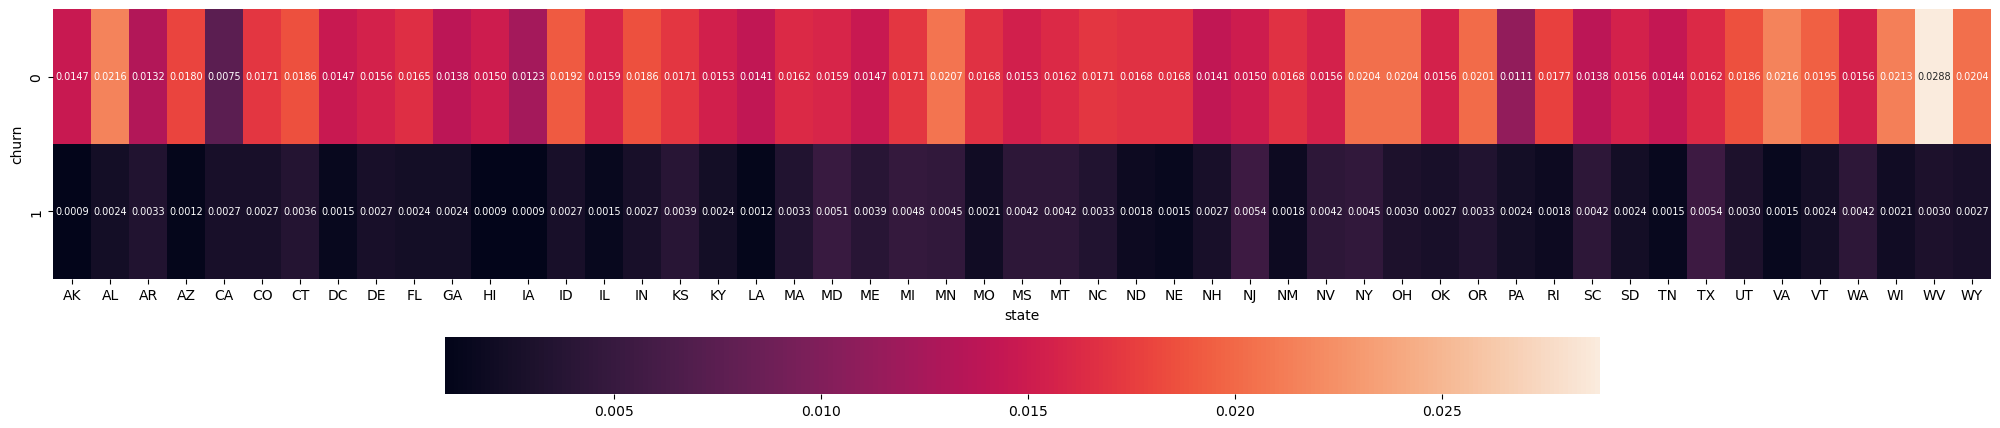

In [23]:
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.heatmap(pd.crosstab(index=X[categorical_columns[0]], columns=y, normalize=True, margins=False).T,
            cbar=True, annot=True, square=False, 
            fmt='.4f', annot_kws={'size': 7},
            cbar_kws={"orientation": "horizontal"})
plt.show()

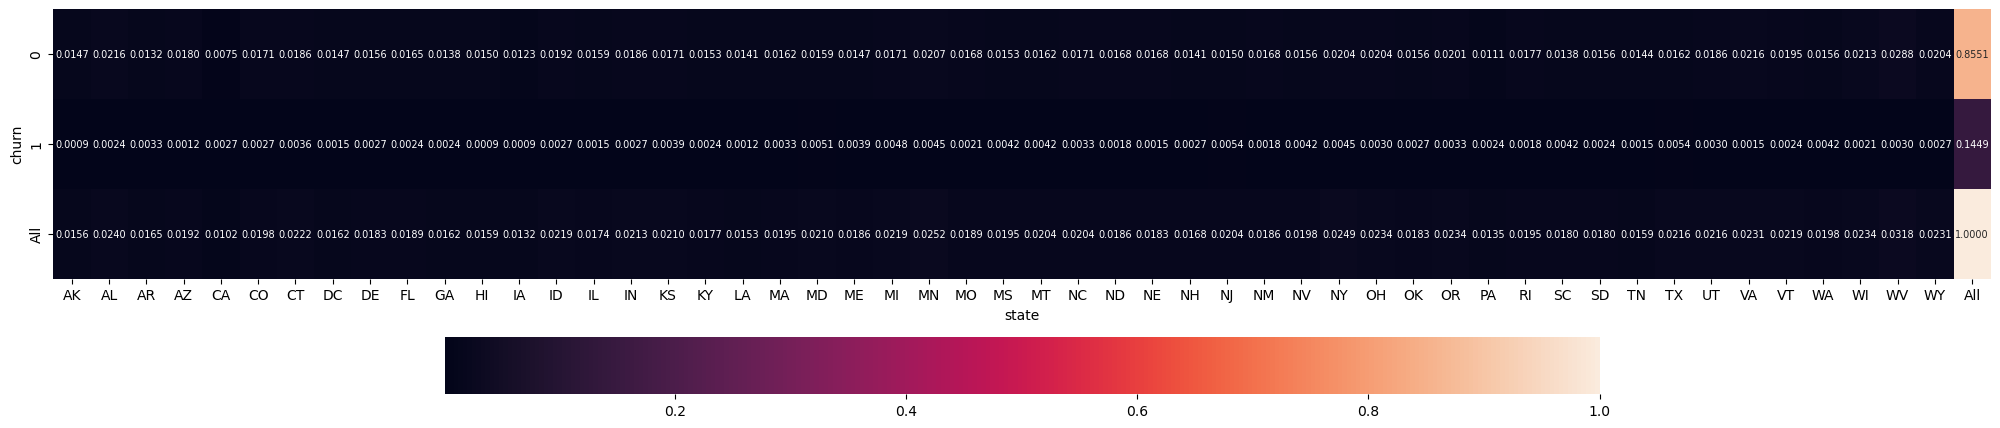

In [24]:
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.heatmap(pd.crosstab(index=X[categorical_columns[0]], columns=y, normalize=True, margins=True).T,
            cbar=True, annot=True, square=False, 
            fmt='.4f', annot_kws={'size': 7},
            cbar_kws={"orientation": "horizontal"})
plt.show()

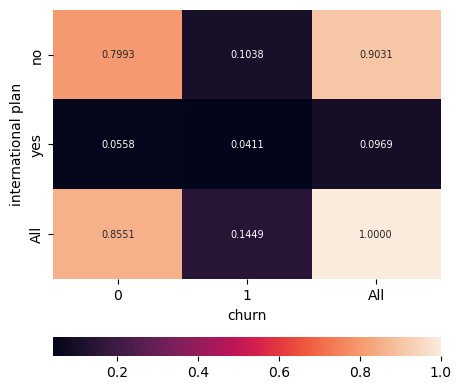

In [25]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(pd.crosstab(index=X[categorical_columns[1]], columns=y, normalize=True, margins=True),
                 cbar=True, annot=True, square=False, 
                fmt='.4f', annot_kws={'size': 7},
                cbar_kws={"orientation": "horizontal"})
plt.show()

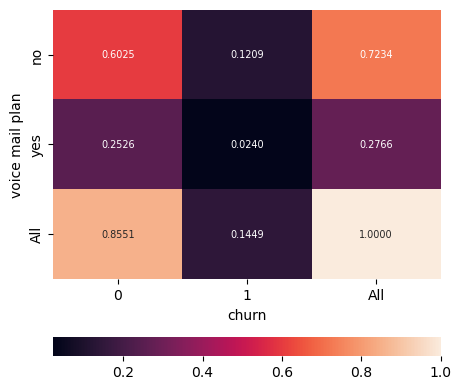

In [26]:
f, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(pd.crosstab(index=X[categorical_columns[2]], columns=y, normalize=True, margins=True),
                 cbar=True, annot=True, square=False, 
                fmt='.4f', annot_kws={'size': 7},
                cbar_kws={"orientation": "horizontal"})
plt.show()

    Не стоит выкидывать categorical variables

#### Quantitive vs Categorical

In [27]:
quantiative_colums[0]

'account length'

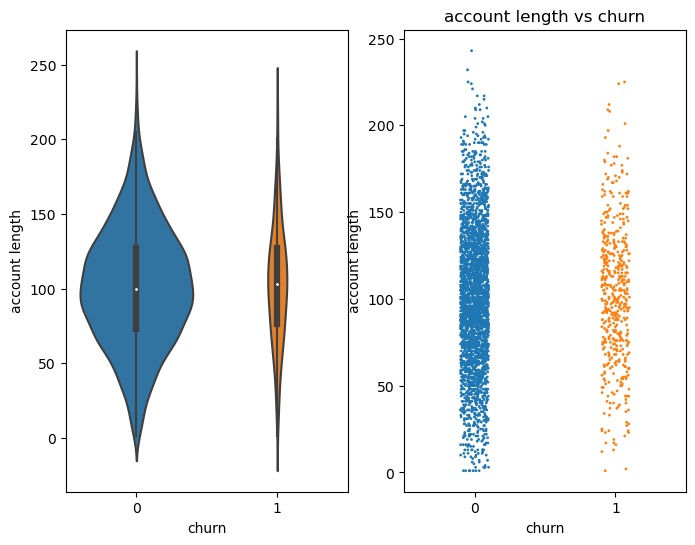

In [28]:
violin_strip_plot(quantiative_colums[0])

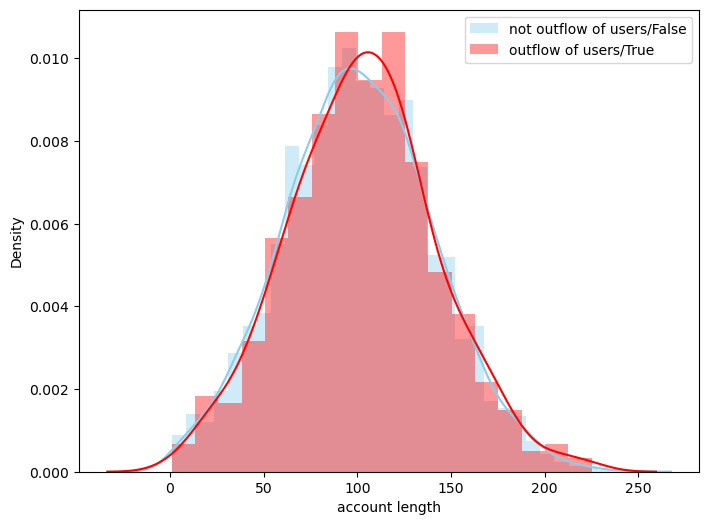

In [29]:
histogram(quantiative_colums[0])

In [30]:
descriptive_stats(quantiative_colums[0])

,0,1
count,2850.000000,483.000000
mean,100.793684,102.664596
std,39.882350,39.467820
min,1.000000,1.000000
25%,73.000000,76.000000
50%,100.000000,103.000000
75%,127.000000,127.000000
max,243.000000,225.000000


In [31]:
count_outliers(quantiative_colums[0])

,0,1
amount,13.000000,5.000000
percent,0.004561,0.010352


    данный параметр никак не предоставляет нам какую либо полезную информацию, так как распределение для True и False практически совпадает, все статистики близки друг к другу

In [32]:
quantiative_colums[1]

'area code'

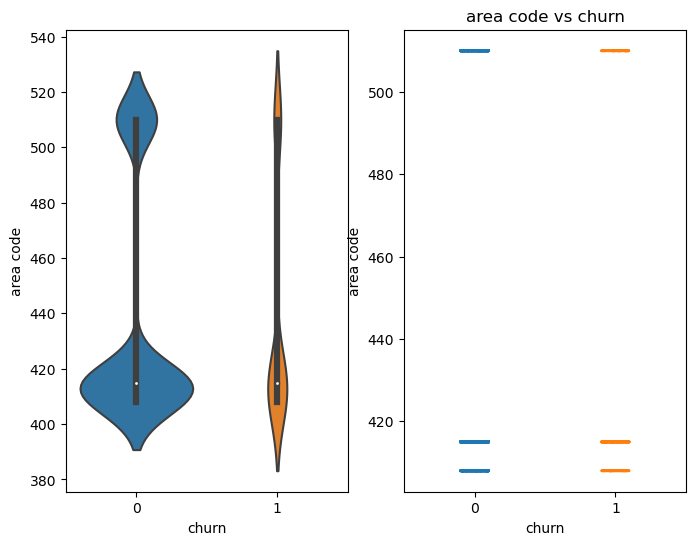

In [33]:
violin_strip_plot(quantiative_colums[1])

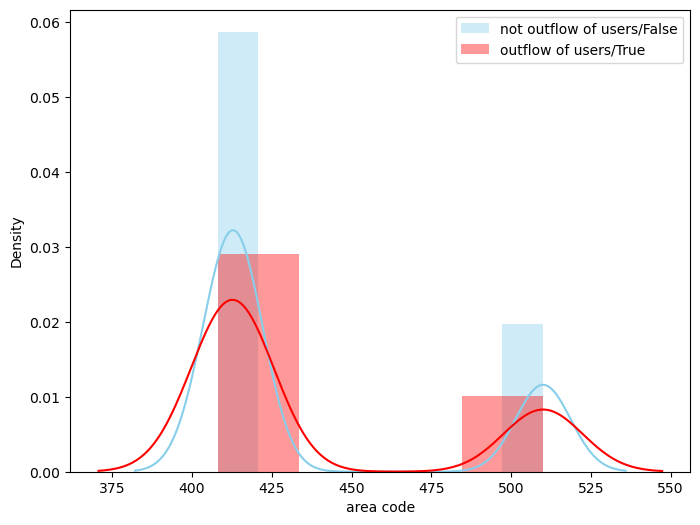

In [34]:
histogram(quantiative_colums[1])

In [35]:
descriptive_stats(quantiative_colums[1])

,0,1
count,2850.000000,483.000000
mean,437.074737,437.817805
std,42.306156,42.792270
min,408.000000,408.000000
25%,408.000000,408.000000
50%,415.000000,415.000000
75%,510.000000,510.000000
max,510.000000,510.000000


In [36]:
count_outliers(quantiative_colums[1])

,0,1
amount,0.0,0.0
percent,0.0,0.0


    данный параметр никак не предоставляет нам какую либо полезную информацию, так как распределение для True и False практически совпадает, все статистики близки друг к другу

In [37]:
quantiative_colums[2]

'number vmail messages'

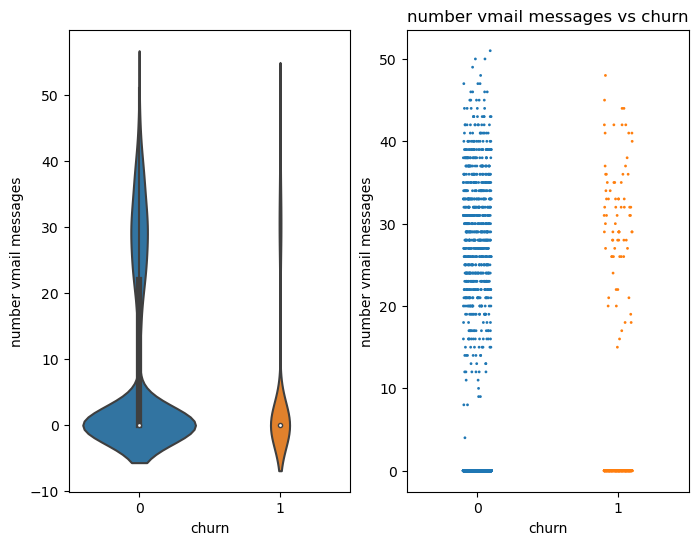

In [38]:
violin_strip_plot(quantiative_colums[2])

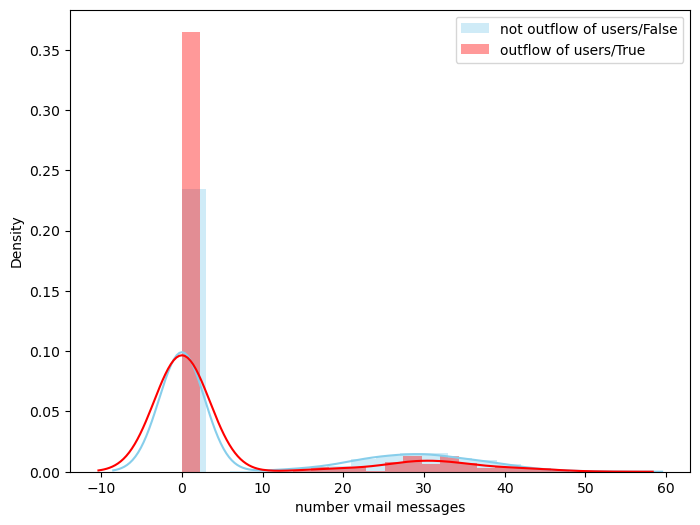

In [39]:
histogram(quantiative_colums[2])

In [40]:
descriptive_stats(quantiative_colums[2])

,0,1
count,2850.000000,483.000000
mean,8.604561,5.115942
std,13.913125,11.860138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,22.000000,0.000000
max,51.000000,48.000000


In [41]:
count_outliers(quantiative_colums[2])

,0,1
amount,0.0,80.000000
percent,0.0,0.165631


In [42]:
sum(X[quantiative_colums[2]] == 0), sum(X[quantiative_colums[2]] != 0), sum(X[quantiative_colums[2]] == 0) / len(X)

(2411, 922, 0.7233723372337234)

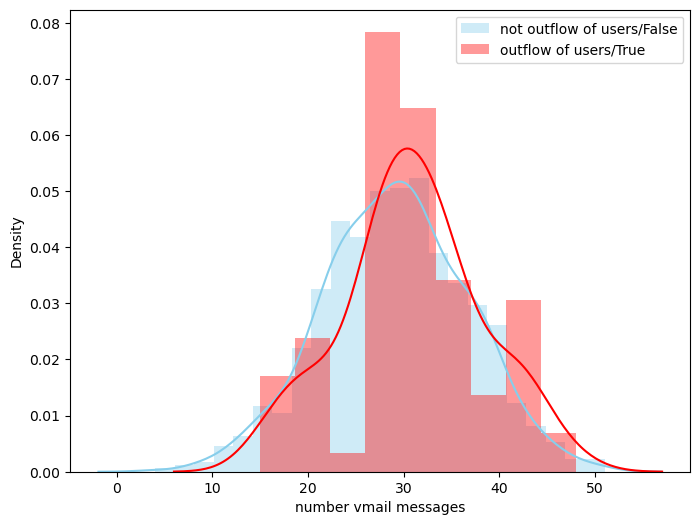

In [43]:
histogram(quantiative_colums[2], data=X[X[quantiative_colums[2]] != 0])

In [44]:
descriptive_stats(quantiative_colums[2], data=X[X[quantiative_colums[2]] != 0])

,0,1
count,842.000000,80.000000
mean,29.124703,30.887500
std,7.576789,7.219863
min,4.000000,15.000000
25%,24.000000,27.000000
50%,29.000000,31.000000
75%,34.000000,35.000000
max,51.000000,48.000000


    У данной переменной много нулей -- 72%, но даже если мы их уберем и посмотрим на данные без нулей, то статистики и распределения прибл равные

In [45]:
quantiative_colums[3]

'total day minutes'

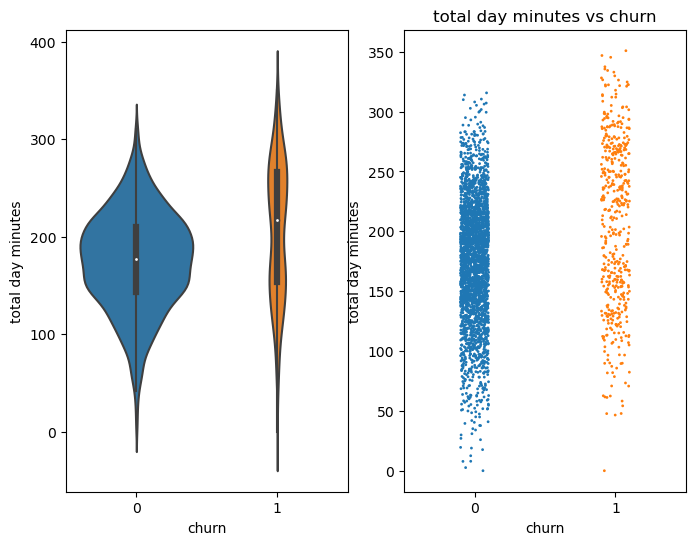

In [46]:
violin_strip_plot(quantiative_colums[3])

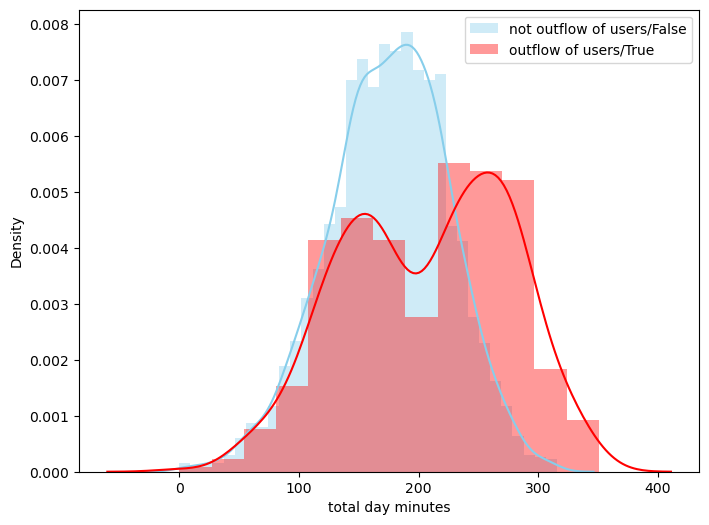

In [47]:
histogram(quantiative_colums[3])

In [48]:
descriptive_stats(quantiative_colums[3])

,0,1
count,2850.000000,483.000000
mean,175.175754,206.914079
std,50.181655,68.997792
min,0.000000,0.000000
25%,142.825000,153.250000
50%,177.200000,217.600000
75%,210.300000,265.950000
max,315.600000,350.800000


In [49]:
count_outliers(quantiative_colums[3])

,0,1
amount,21.000000,0.0
percent,0.007368,0.0


    переменная для значения True имеет отличное распределие от распределения для значения False
    так же статистики отличаются
    std    -- 50  vs 69
    Q1     -- 142 vs 153
    Q2     -- 177 vs 218
    Q3     -- 210 vs 266

In [50]:
quantiative_colums[4]

'total day calls'

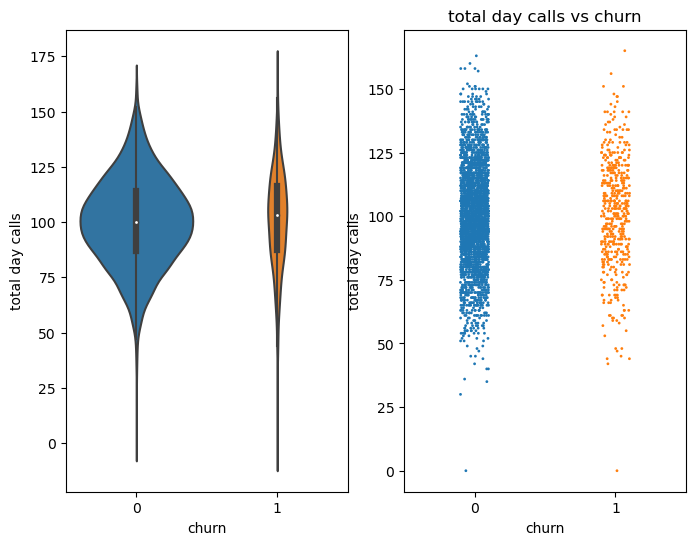

In [51]:
violin_strip_plot(quantiative_colums[4])

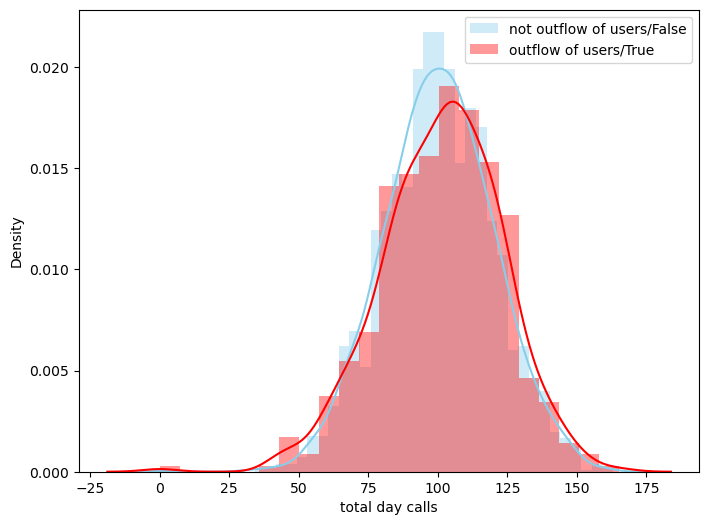

In [52]:
histogram(quantiative_colums[4])

In [53]:
descriptive_stats(quantiative_colums[4])

,0,1
count,2850.000000,483.000000
mean,100.283158,101.335404
std,19.801157,21.582307
min,0.000000,0.000000
25%,87.000000,87.500000
50%,100.000000,103.000000
75%,114.000000,116.500000
max,163.000000,165.000000


In [54]:
count_outliers(quantiative_colums[4])

,0,1
amount,16.000000,3.000000
percent,0.005614,0.006211


    данный параметр никак не предоставляет нам какую либо полезную информацию, так как распределение для True и False практически совпадает, все статистики близки друг к другу

In [55]:
quantiative_colums[5]

'total day charge'

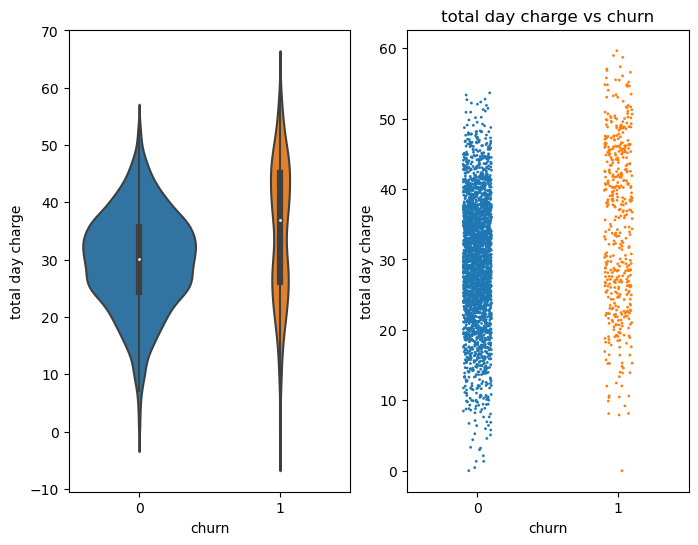

In [56]:
violin_strip_plot(quantiative_colums[5])

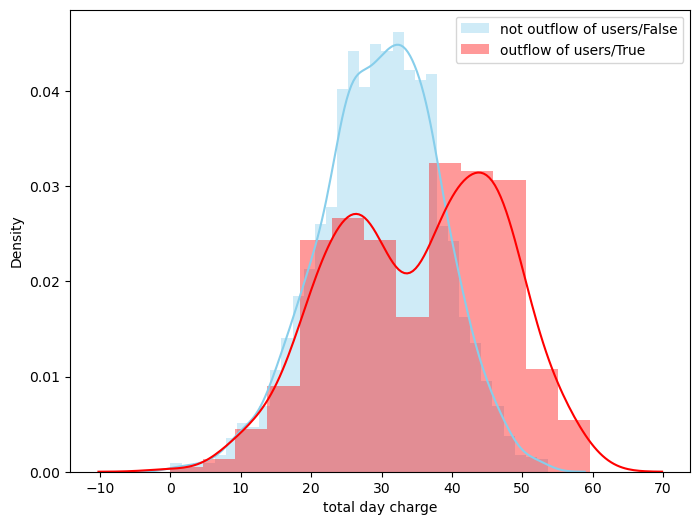

In [57]:
histogram(quantiative_colums[5])

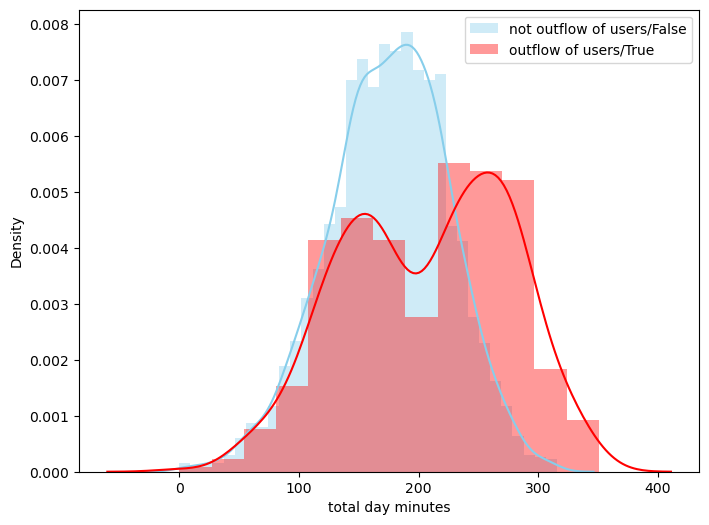

In [58]:
histogram(quantiative_colums[3])

In [59]:
descriptive_stats(quantiative_colums[5])

,0,1
count,2850.000000,483.000000
mean,29.780421,35.175921
std,8.530835,11.729710
min,0.000000,0.000000
25%,24.282500,26.055000
50%,30.120000,36.990000
75%,35.750000,45.210000
max,53.650000,59.640000


In [60]:
count_outliers(quantiative_colums[5])

,0,1
amount,21.000000,0.0
percent,0.007368,0.0


In [61]:
X[[quantiative_colums[3], quantiative_colums[5]]].corr()

,total day minutes,total day charge
total day minutes,1.0,1.0
total day charge,1.0,1.0


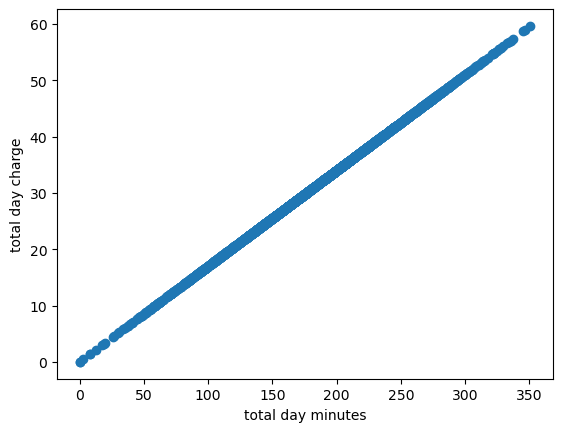

In [62]:
plt.scatter(X[quantiative_colums[3]], X[quantiative_colums[5]])
plt.xlabel(quantiative_colums[3])
plt.ylabel(quantiative_colums[5])
plt.show()

    `total day charge` очень похож на `total day minutes` по распределению
    переменная для значения True имеет отличное распределие от распределения для значения False
    так же статистики отличаются
    std    -- 29  vs 35
    Q2     -- 30 vs 37
    Q3     -- 36 vs 45
    одну переменную из двух можно будет убрать

In [63]:
columns_to_delete.append([quantiative_colums[3], quantiative_colums[5]])

In [64]:
quantiative_colums[6]

'total eve minutes'

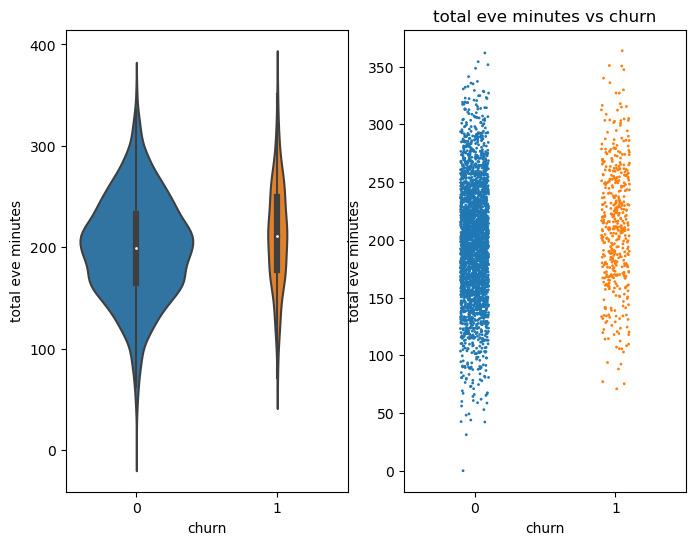

In [65]:
violin_strip_plot(quantiative_colums[6])

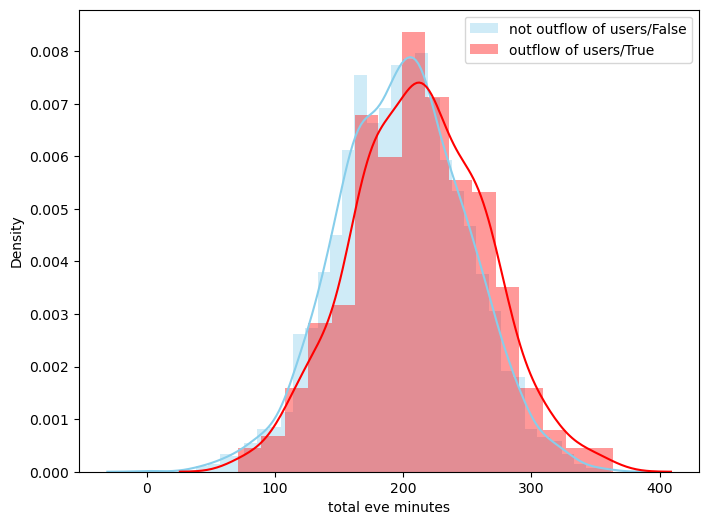

In [66]:
histogram(quantiative_colums[6])

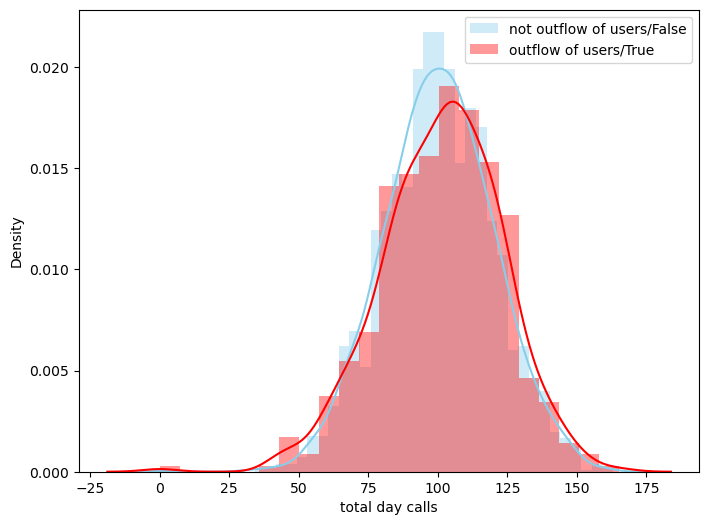

In [67]:
histogram(quantiative_colums[4])

In [68]:
X[[quantiative_colums[4], quantiative_colums[6]]].corr()

,total day calls,total eve minutes
total day calls,1.000000,-0.021451
total eve minutes,-0.021451,1.000000


In [69]:
X[y == True][[quantiative_colums[4], quantiative_colums[6]]].corr()

,total day calls,total eve minutes
total day calls,1.000000,0.074291
total eve minutes,0.074291,1.000000


In [70]:
X[y == False][[quantiative_colums[4], quantiative_colums[6]]].corr()

,total day calls,total eve minutes
total day calls,1.000000,-0.041779
total eve minutes,-0.041779,1.000000


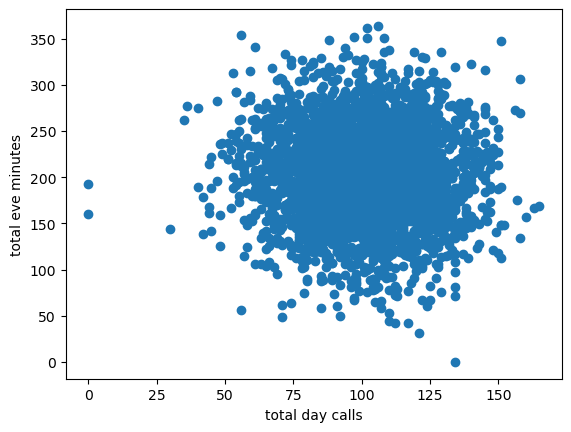

In [71]:
plt.scatter(X[quantiative_colums[4]], X[quantiative_colums[6]])
plt.xlabel(quantiative_colums[4])
plt.ylabel(quantiative_colums[6])
plt.show()

In [72]:
descriptive_stats(quantiative_colums[6])

,0,1
count,2850.000000,483.000000
mean,199.043298,212.410145
std,50.292175,51.728910
min,0.000000,70.900000
25%,164.500000,177.100000
50%,199.600000,211.300000
75%,233.200000,249.450000
max,361.800000,363.700000


In [73]:
count_outliers(quantiative_colums[6])

,0,1
amount,19.000000,1.00000
percent,0.006667,0.00207


    `total eve minutes` распределения похожи на `total day calls` 
    данный параметр никак не предоставляет нам какую либо полезную информацию, так как распределение для True и False практически совпадает, все статистики близки друг к другу
    хоть распределения похожи, но они не коррелирует
    посмотрел scatter plot, никакой функциональной зависимости не найдено

In [74]:
quantiative_colums[7]

'total eve calls'

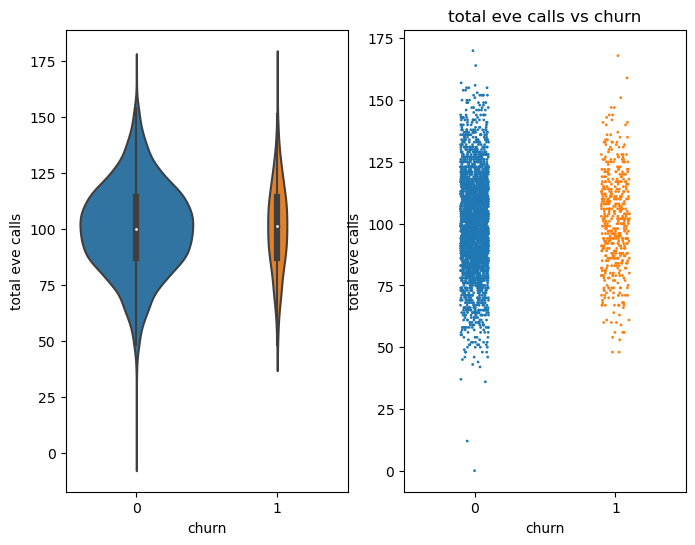

In [75]:
violin_strip_plot(quantiative_colums[7])

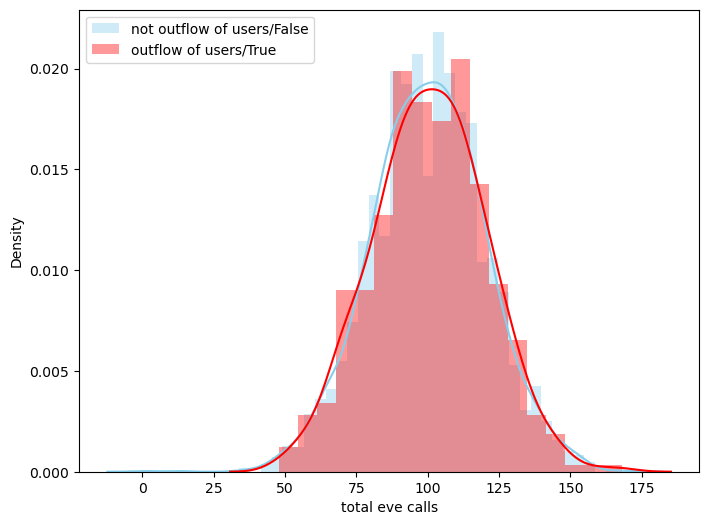

In [76]:
histogram(quantiative_colums[7])

In [77]:
descriptive_stats(quantiative_colums[7])

,0,1
count,2850.000000,483.000000
mean,100.038596,100.561077
std,19.958414,19.724711
min,0.000000,48.000000
25%,87.000000,87.000000
50%,100.000000,101.000000
75%,114.000000,114.000000
max,170.000000,168.000000


In [78]:
count_outliers(quantiative_colums[7])

,0,1
amount,18.000000,2.000000
percent,0.006316,0.004141


    Распределения снова практически совпадают, возможно оно коррелирует с другими, проверим это

In [79]:
X[[quantiative_colums[4], quantiative_colums[6], quantiative_colums[7]]].corr()

,total day calls,total eve minutes,total eve calls
total day calls,1.000000,-0.021451,0.006462
total eve minutes,-0.021451,1.000000,-0.011430
total eve calls,0.006462,-0.011430,1.000000


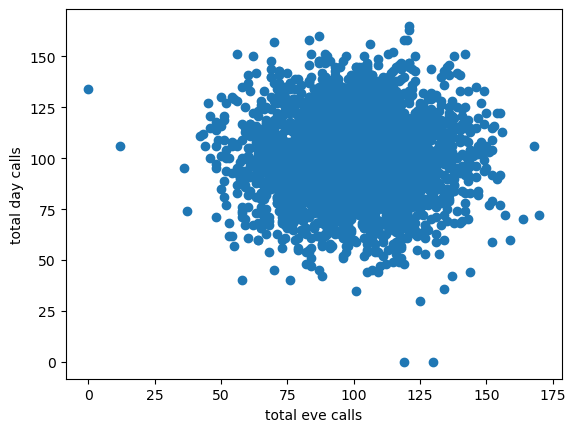

In [80]:
plt.scatter(X[quantiative_colums[7]], X[quantiative_colums[4]])
plt.xlabel(quantiative_colums[7])
plt.ylabel(quantiative_colums[4])
plt.show()

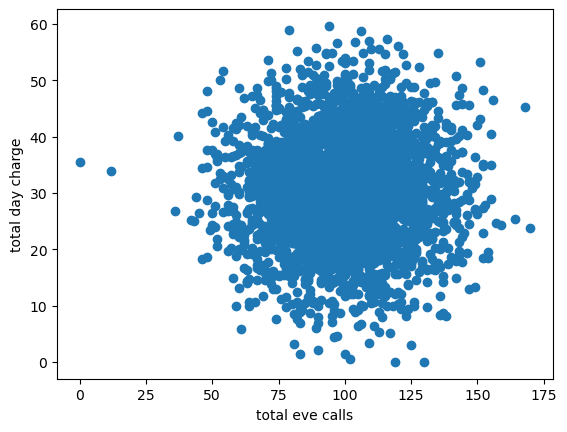

In [81]:
plt.scatter(X[quantiative_colums[7]], X[quantiative_colums[5]])
plt.xlabel(quantiative_colums[7])
plt.ylabel(quantiative_colums[5])
plt.show()

    Нет никакой зависимости между `total eve calls` и `total day calls`, `total day charge`

In [82]:
quantiative_colums[8]

'total eve charge'

In [83]:
descriptive_stats(quantiative_colums[8])

,0,1
count,2850.000000,483.000000
mean,16.918909,18.054969
std,4.274863,4.396762
min,0.000000,6.030000
25%,13.980000,15.055000
50%,16.970000,17.960000
75%,19.820000,21.205000
max,30.750000,30.910000


In [84]:
count_outliers(quantiative_colums[8])

,0,1
amount,19.000000,1.00000
percent,0.006667,0.00207


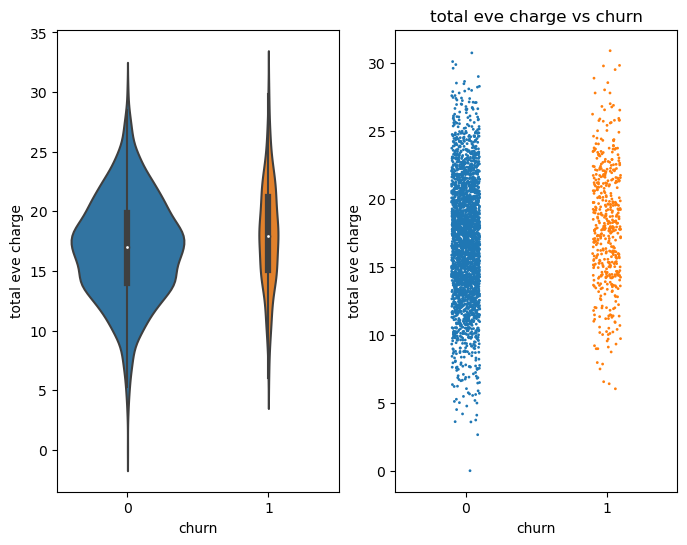

In [85]:
violin_strip_plot(quantiative_colums[8])

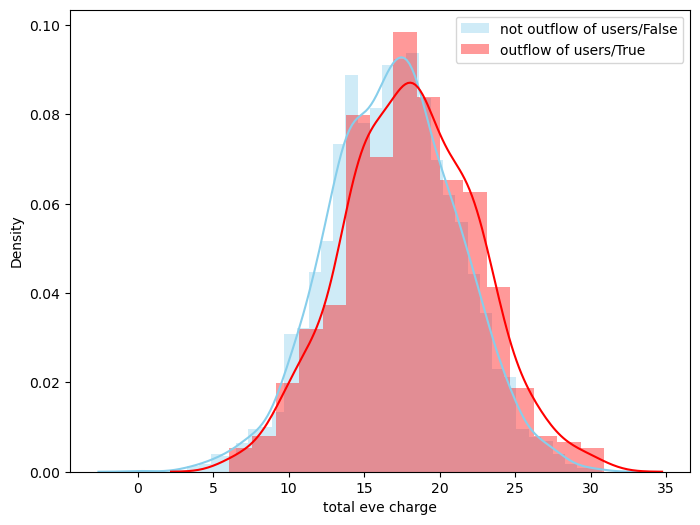

In [86]:
histogram(quantiative_colums[8])

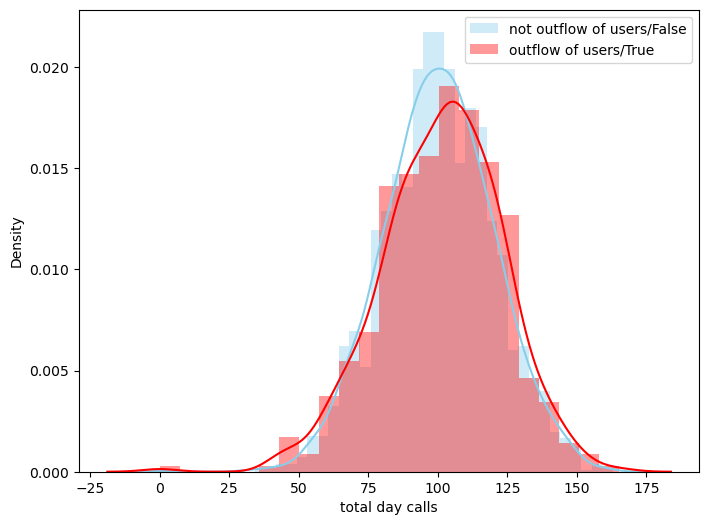

In [87]:
histogram(quantiative_colums[4])

In [88]:
X[[quantiative_colums[4], quantiative_colums[8]]].corr()

,total day calls,total eve charge
total day calls,1.000000,-0.021449
total eve charge,-0.021449,1.000000


In [89]:
X[[quantiative_colums[6], quantiative_colums[8]]].corr()

,total eve minutes,total eve charge
total eve minutes,1.0,1.0
total eve charge,1.0,1.0


In [90]:
columns_to_delete.append([quantiative_colums[6], quantiative_colums[8]])

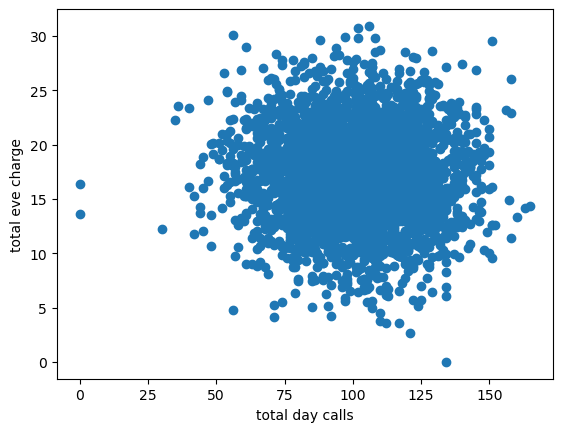

In [91]:
plt.scatter(X[quantiative_colums[4]], X[quantiative_colums[8]])
plt.xlabel(quantiative_colums[4])
plt.ylabel(quantiative_colums[8])
plt.show()

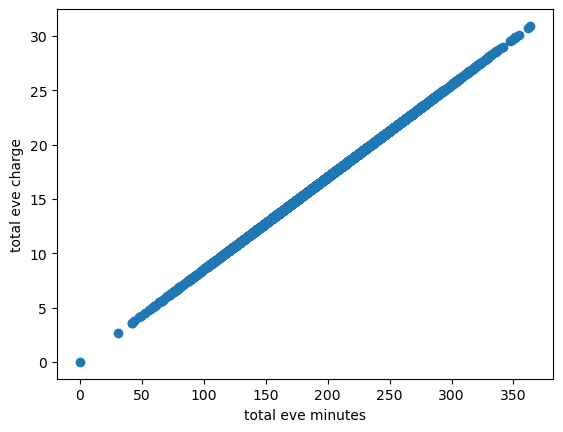

In [92]:
plt.scatter(X[quantiative_colums[6]], X[quantiative_colums[8]])
plt.xlabel(quantiative_colums[6])
plt.ylabel(quantiative_colums[8])
plt.show()

    Одну из двух переменных можно убрать

In [93]:
quantiative_colums[9]

'total night minutes'

In [94]:
descriptive_stats(quantiative_colums[9])

,0,1
count,2850.000000,483.000000
mean,200.133193,205.231677
std,51.105032,47.132825
min,23.200000,47.400000
25%,165.900000,171.250000
50%,200.250000,204.800000
75%,234.900000,239.850000
max,395.000000,354.900000


In [95]:
count_outliers(quantiative_colums[9])

,0,1
amount,25.000000,2.000000
percent,0.008772,0.004141


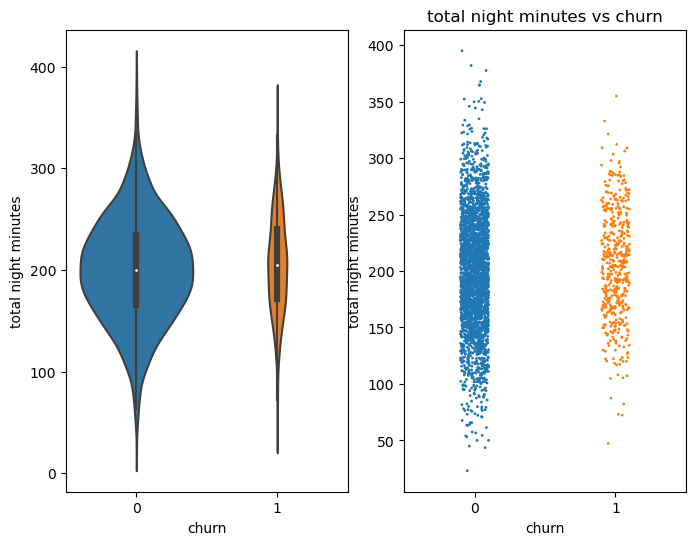

In [96]:
violin_strip_plot(quantiative_colums[9])

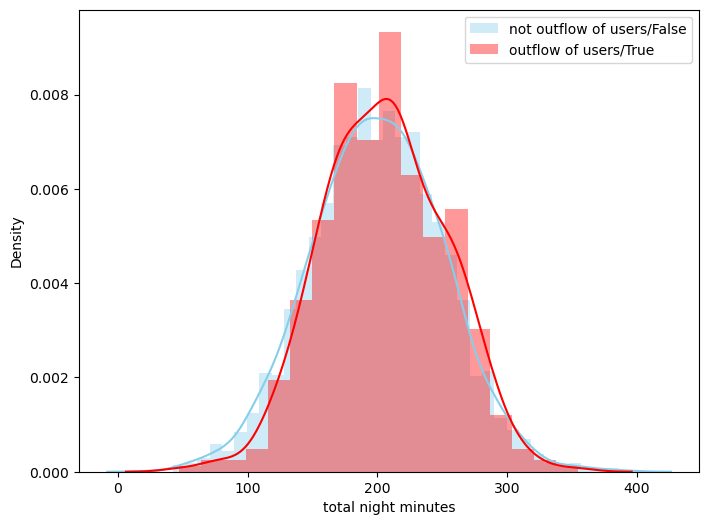

In [97]:
histogram(quantiative_colums[9])

    Распределения снова практически совпадают, возможно оно коррелирует с другими, проверим это

In [98]:
X[[quantiative_colums[4], quantiative_colums[8], quantiative_colums[5], quantiative_colums[6], quantiative_colums[9]]].corr()

,total day calls,total eve charge,total day charge,total eve minutes,total night minutes
total day calls,1.000000,-0.021449,0.006753,-0.021451,0.022938
total eve charge,-0.021449,1.000000,0.007036,1.000000,-0.012592
total day charge,0.006753,0.007036,1.000000,0.007050,0.004324
total eve minutes,-0.021451,1.000000,0.007050,1.000000,-0.012584
total night minutes,0.022938,-0.012592,0.004324,-0.012584,1.000000


In [99]:
quantiative_colums[10]

'total night calls'

In [100]:
descriptive_stats(quantiative_colums[10])

,0,1
count,2850.000000,483.000000
mean,100.058246,100.399586
std,19.506246,19.950659
min,33.000000,49.000000
25%,87.000000,85.000000
50%,100.000000,100.000000
75%,113.000000,115.000000
max,175.000000,158.000000


In [101]:
count_outliers(quantiative_colums[10])

,0,1
amount,21.000000,0.0
percent,0.007368,0.0


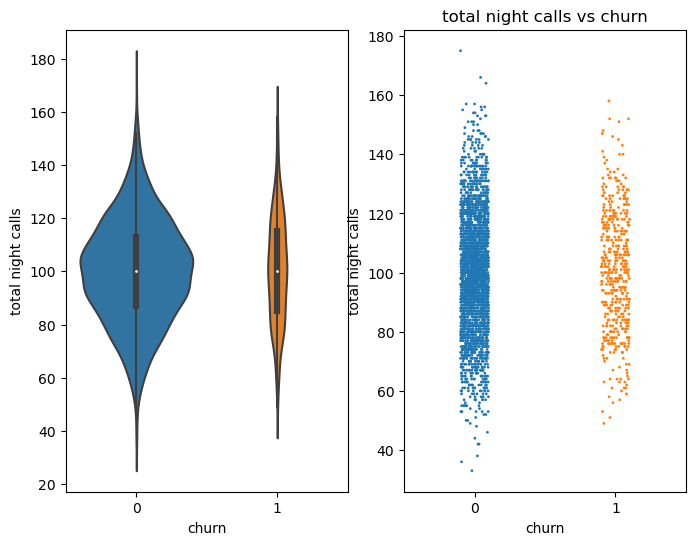

In [102]:
violin_strip_plot(quantiative_colums[10])

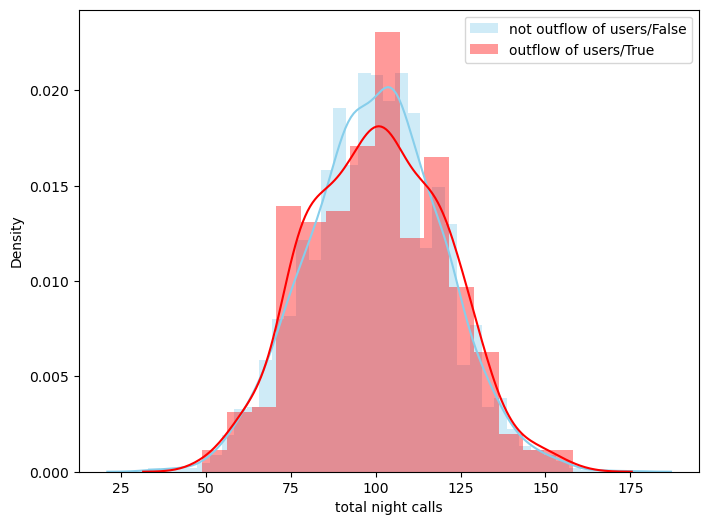

In [103]:
histogram(quantiative_colums[10])

In [104]:
X[[quantiative_colums[4], quantiative_colums[8], quantiative_colums[5], quantiative_colums[6], quantiative_colums[9], quantiative_colums[10]]].corr()

,total day calls,total eve charge,total day charge,total eve minutes,total night minutes,total night calls
total day calls,1.000000,-0.021449,0.006753,-0.021451,0.022938,-0.019557
total eve charge,-0.021449,1.000000,0.007036,1.000000,-0.012592,0.007596
total day charge,0.006753,0.007036,1.000000,0.007050,0.004324,0.022972
total eve minutes,-0.021451,1.000000,0.007050,1.000000,-0.012584,0.007586
total night minutes,0.022938,-0.012592,0.004324,-0.012584,1.000000,0.011204
total night calls,-0.019557,0.007596,0.022972,0.007586,0.011204,1.000000


        Распределения снова практически совпадают, за исключением того что для False случая распределение больше сконцентрирована в mean or median

In [105]:
quantiative_colums[11]

'total night charge'

In [106]:
descriptive_stats(quantiative_colums[11])

,0,1
count,2850.000000,483.000000
mean,9.006074,9.235528
std,2.299768,2.121081
min,1.040000,2.130000
25%,7.470000,7.705000
50%,9.010000,9.220000
75%,10.570000,10.795000
max,17.770000,15.970000


In [107]:
count_outliers(quantiative_colums[11])

,0,1
amount,25.000000,2.000000
percent,0.008772,0.004141


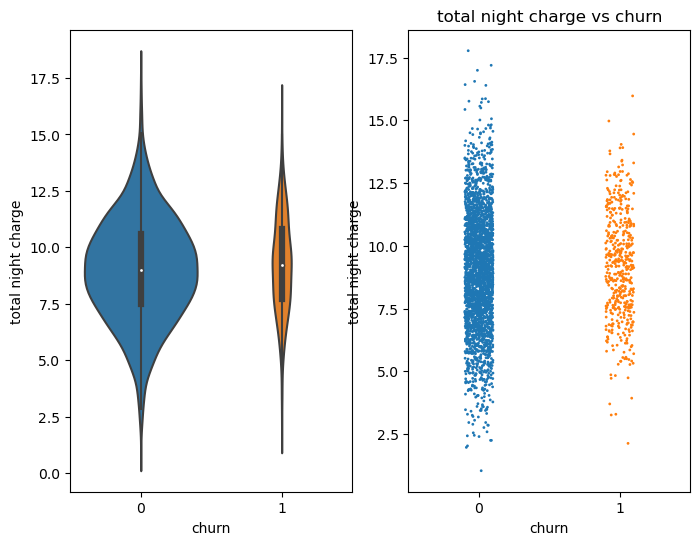

In [108]:
violin_strip_plot(quantiative_colums[11])

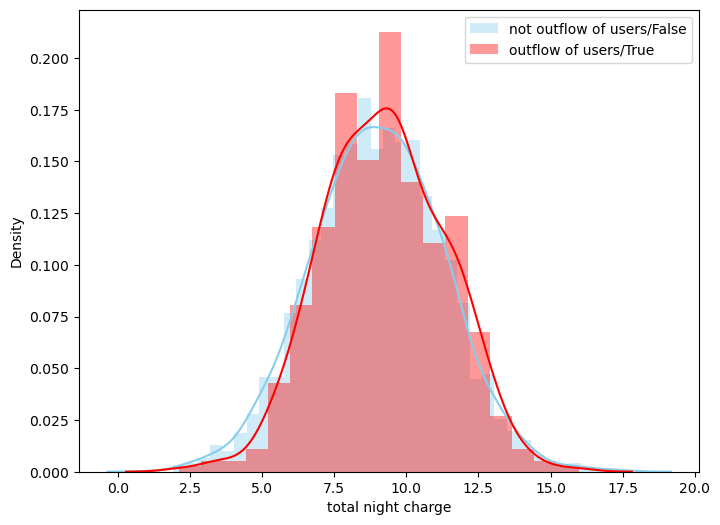

In [109]:
histogram(quantiative_colums[11])

In [110]:
X[[quantiative_colums[9], quantiative_colums[11]]].corr()

,total night minutes,total night charge
total night minutes,1.000000,0.999999
total night charge,0.999999,1.000000


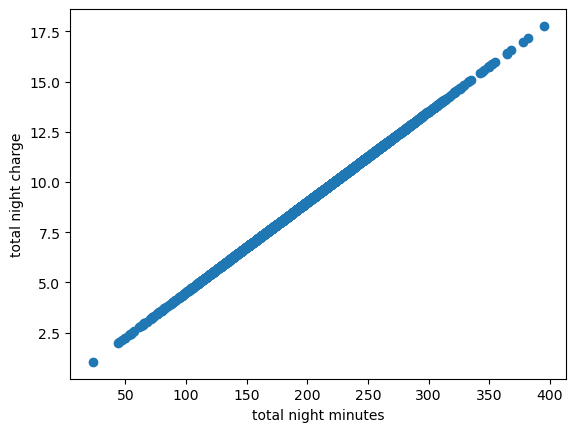

In [111]:
plt.scatter(X[quantiative_colums[9]], X[quantiative_colums[11]])
plt.xlabel(quantiative_colums[9])
plt.ylabel(quantiative_colums[11])
plt.show()

    Одну из двух переменных можно удалить

In [112]:
columns_to_delete.append([quantiative_colums[9], quantiative_colums[11]])

In [113]:
quantiative_colums[12]

'total intl minutes'

In [114]:
descriptive_stats(quantiative_colums[12])

,0,1
count,2850.000000,483.00000
mean,10.158877,10.70000
std,2.784489,2.79319
min,0.000000,2.00000
25%,8.400000,8.80000
50%,10.200000,10.60000
75%,12.000000,12.80000
max,18.900000,20.00000


In [115]:
count_outliers(quantiative_colums[12])

,0,1
amount,42.000000,2.000000
percent,0.014737,0.004141


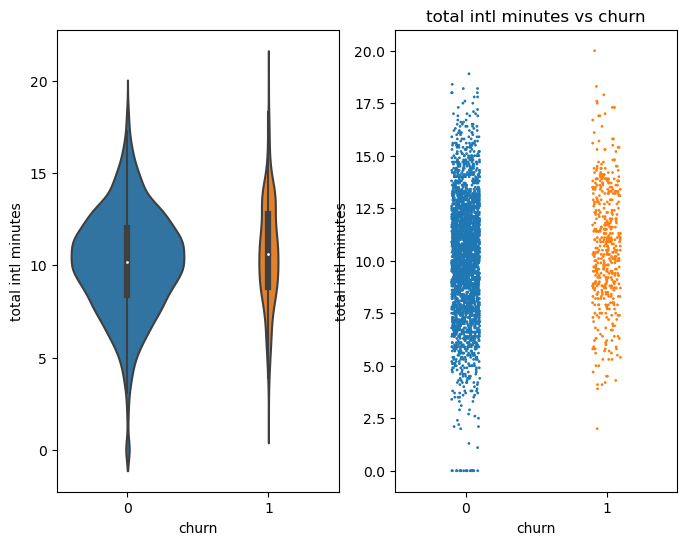

In [116]:
violin_strip_plot(quantiative_colums[12])

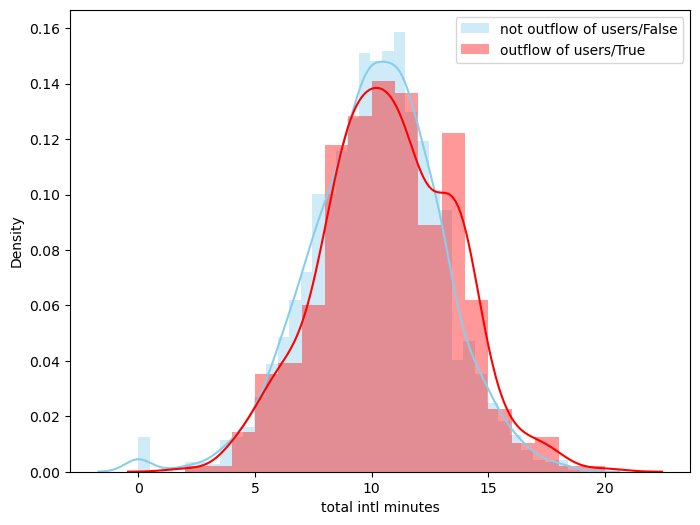

In [117]:
histogram(quantiative_colums[12])

    У False случая распределение имеет много значений в значении = 10, так же выделяется значение 0, у False случая так же в 10, но и в ~14

In [118]:
quantiative_colums[13]

'total intl calls'

In [119]:
descriptive_stats(quantiative_colums[13])

,0,1
count,2850.000000,483.000000
mean,4.532982,4.163561
std,2.441984,2.551575
min,0.000000,1.000000
25%,3.000000,2.000000
50%,4.000000,4.000000
75%,6.000000,5.000000
max,19.000000,20.000000


In [120]:
count_outliers(quantiative_colums[13])

,0,1
amount,67.000000,19.000000
percent,0.023509,0.039337


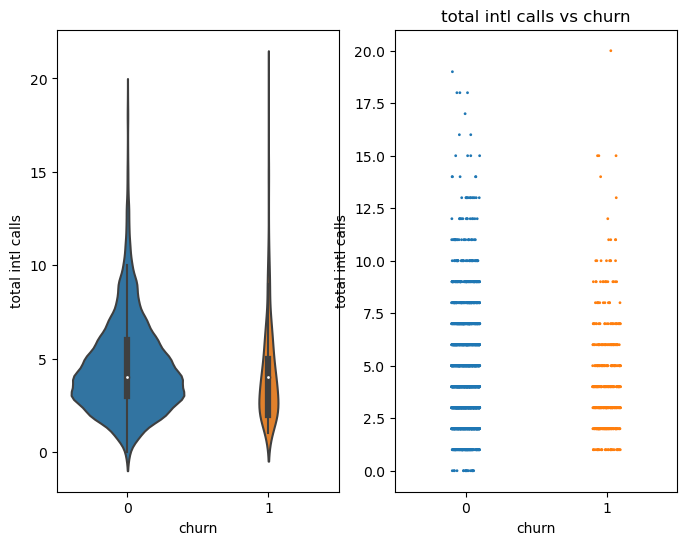

In [121]:
violin_strip_plot(quantiative_colums[13])

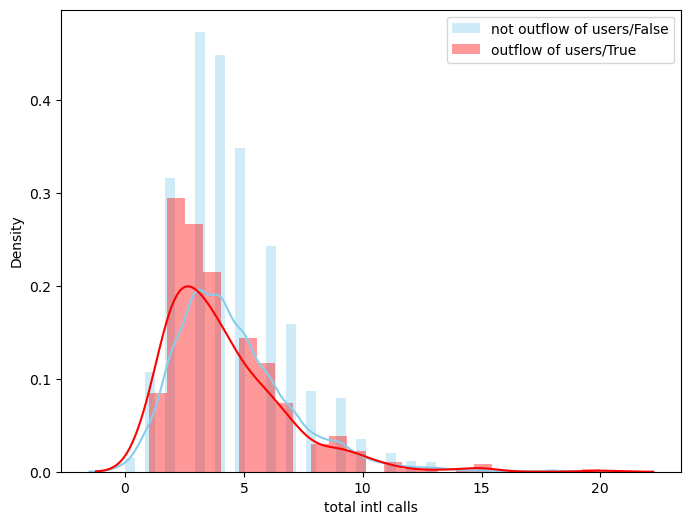

In [122]:
histogram(quantiative_colums[13])

    данный параметр никак не предоставляет нам какую либо полезную информацию, так как распределение для True и False практически совпадает, все статистики близки друг к другу

In [123]:
quantiative_colums[14]

'total intl charge'

In [124]:
descriptive_stats(quantiative_colums[14])

,0,1
count,2850.000000,483.000000
mean,2.743404,2.889545
std,0.751784,0.754152
min,0.000000,0.540000
25%,2.270000,2.380000
50%,2.750000,2.860000
75%,3.240000,3.460000
max,5.100000,5.400000


In [125]:
count_outliers(quantiative_colums[14])

,0,1
amount,42.000000,2.000000
percent,0.014737,0.004141


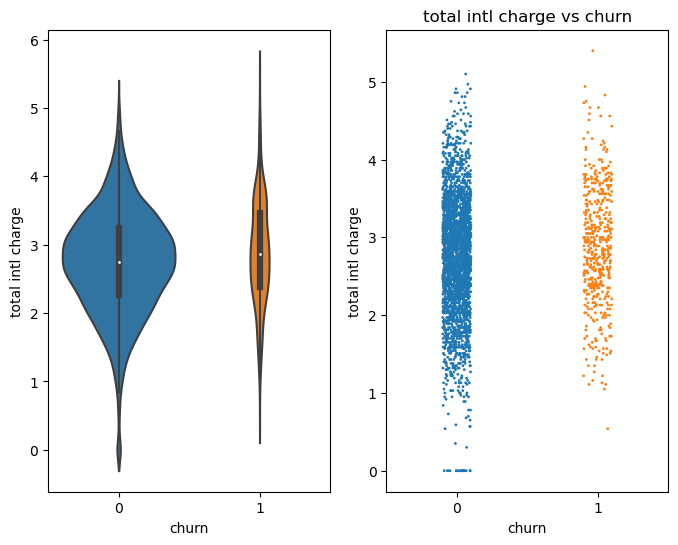

In [126]:
violin_strip_plot(quantiative_colums[14])

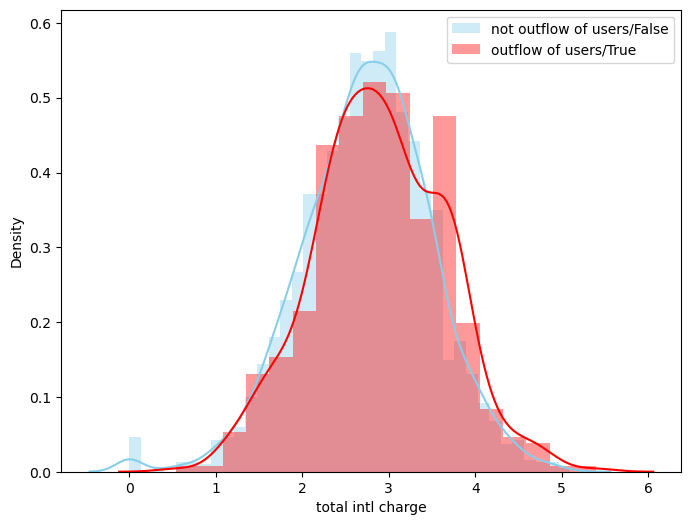

In [127]:
histogram(quantiative_colums[14])

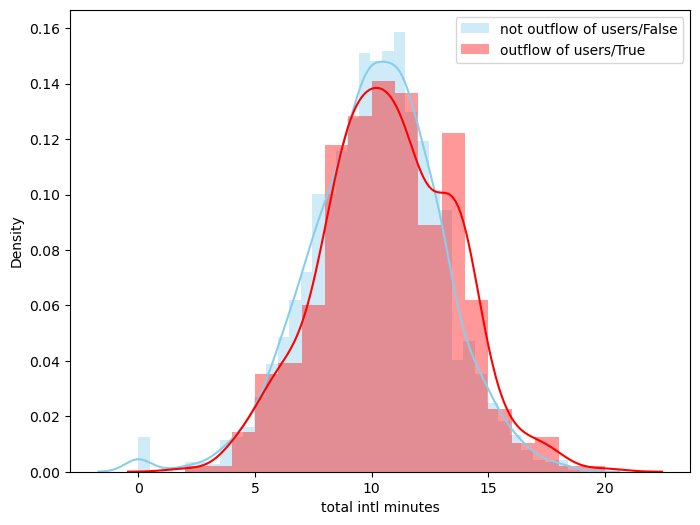

In [128]:
histogram(quantiative_colums[12])

In [129]:
X[[quantiative_colums[12], quantiative_colums[14]]].corr()

,total intl minutes,total intl charge
total intl minutes,1.000000,0.999993
total intl charge,0.999993,1.000000


    Эти две переменные сильно коррелируют, одну из них можно выкинуть

In [130]:
columns_to_delete.append([quantiative_colums[12], quantiative_colums[14]])

In [131]:
quantiative_colums[15]

'customer service calls'

In [132]:
descriptive_stats(quantiative_colums[15])

,0,1
count,2850.000000,483.000000
mean,1.449825,2.229814
std,1.163883,1.853275
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,2.000000,4.000000
max,8.000000,9.000000


In [133]:
count_outliers(quantiative_colums[15])

,0,1
amount,129.000000,2.000000
percent,0.045263,0.004141


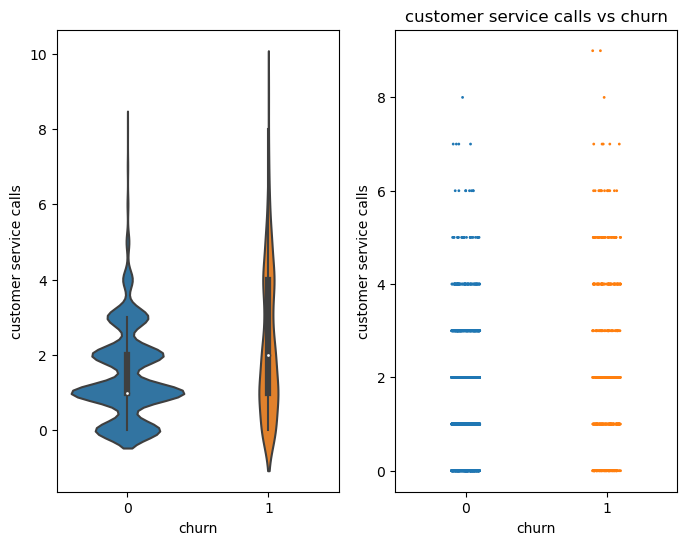

In [134]:
violin_strip_plot(quantiative_colums[15])

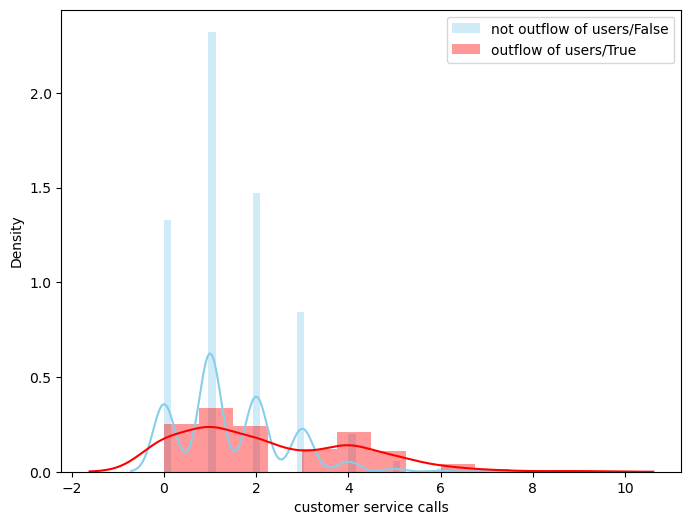

In [135]:
histogram(quantiative_colums[15])

    У данной переменной отличаются распределения и статистики

In [136]:
columns_to_delete

[['total day minutes', 'total day charge'],
 ['total eve minutes', 'total eve charge'],
 ['total night minutes', 'total night charge'],
 ['total intl minutes', 'total intl charge']]

In [137]:
[x[0] for x in columns_to_delete]

['total day minutes',
 'total eve minutes',
 'total night minutes',
 'total intl minutes']

In [138]:
X.drop(columns=[x[0] for x in columns_to_delete], inplace=True)

In [139]:
X.shape, y.shape

((3333, 15), (3333,))

In [140]:
X.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
0,KS,128,415,no,yes,25,110,45.07,99,16.78,91,11.01,3,2.70,1
1,OH,107,415,no,yes,26,123,27.47,103,16.62,103,11.45,3,3.70,1
2,NJ,137,415,no,no,0,114,41.38,110,10.30,104,7.32,5,3.29,0
3,OH,84,408,yes,no,0,71,50.90,88,5.26,89,8.86,7,1.78,2
4,OK,75,415,yes,no,0,113,28.34,122,12.61,121,8.41,3,2.73,3


In [141]:
X["international plan"] = (X["international plan"] == "yes").astype(int)

In [142]:
X["voice mail plan"] = (X["voice mail plan"] == "yes").astype(int)

In [143]:
X.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
0,KS,128,415,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1
1,OH,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1
2,NJ,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0
3,OH,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2
4,OK,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3


In [144]:
X.drop(columns="state", inplace=True)

In [145]:
X.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls
0,128,415,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1
1,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1
2,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0
3,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2
4,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3


In [146]:
X.shape

(3333, 14)

In [147]:
from sklearn.tree import DecisionTreeClassifier

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

In [150]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2833, 14), (500, 14), (2833,), (500,))

In [151]:
DT_classifier = DecisionTreeClassifier(random_state=42) # with default parameters

In [152]:
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [153]:
DT_classifier.score(X_test, y_test)

0.916

In [154]:
cross_val_score(DT_classifier, X, y, cv=5).mean()

0.9162914038476258

In [155]:
params_max_depth = {
    "criterion": ["entropy"],
    "max_depth": range(1, 20),
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2],
}

In [156]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_depth, n_jobs=6, cv=5, verbose=False)

In [157]:
model = gridsearch_tree.fit(X_train, y_train)

In [158]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [159]:
params_max_features = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": range(15),
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2]
}

In [160]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_features, n_jobs=6, cv=5, verbose=False)

In [161]:
model = gridsearch_tree.fit(X_train, y_train)

In [162]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 12,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [163]:
params_max_leaf_nodes = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": range(1, 30),
    "min_samples_leaf": [2]
}

In [164]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_leaf_nodes, n_jobs=6, cv=5, verbose=False)

In [165]:
model = gridsearch_tree.fit(X_train, y_train)

In [166]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 28,
 'min_samples_leaf': 2}

In [167]:
params_min_samples_leaf = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": range(2, 20)
}

In [168]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_min_samples_leaf, n_jobs=6, cv=5, verbose=False)

In [169]:
model = gridsearch_tree.fit(X_train, y_train)

In [170]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 15}

In [171]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None, *range(4, 9)],
    "max_features": [None, *range(10, 15)],
    "max_leaf_nodes": [None, *range(22, 30)],
    "min_samples_leaf": [2, *range(13, 18)]
}

In [172]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params, n_jobs=6, cv=5, verbose=False)

In [173]:
model = gridsearch_tree.fit(X_train, y_train)

In [174]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 28,
 'min_samples_leaf': 2}

In [175]:
model.best_score_

0.9435245947613439

In [176]:
model.score(X_test, y_test)

0.94

#### with dummies

In [177]:
X_dummies = pd.get_dummies(telecom_df.state, prefix="state")

In [178]:
X = pd.concat([X, X_dummies], axis=1)

In [179]:
X.shape

(3333, 65)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)

In [181]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2833, 65), (500, 65), (2833,), (500,))

In [182]:
DT_classifier = DecisionTreeClassifier(random_state=42) # with default parameters

In [183]:
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [184]:
DT_classifier.score(X_test, y_test)

0.91

In [185]:
cross_val_score(DT_classifier, X, y, cv=5).mean()

0.9207900554227392

In [186]:
params_max_depth = {
    "criterion": ["entropy"],
    "max_depth": range(1, 20),
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2],
}

In [187]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_depth, n_jobs=6, cv=5, verbose=False)

In [188]:
model = gridsearch_tree.fit(X_train, y_train)

In [189]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [190]:
params_max_features = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": range(66),
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2]
}

In [191]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_features, n_jobs=6, cv=5, verbose=False)

In [192]:
model = gridsearch_tree.fit(X_train, y_train)

In [193]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 42,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [194]:
params_max_leaf_nodes = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": range(1, 30),
    "min_samples_leaf": [2]
}

In [195]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_leaf_nodes, n_jobs=6, cv=5, verbose=False)

In [196]:
model = gridsearch_tree.fit(X_train, y_train)

In [197]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 28,
 'min_samples_leaf': 2}

In [198]:
params_min_samples_leaf = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": range(2, 20)
}

In [199]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_min_samples_leaf, n_jobs=6, cv=5, verbose=False)

In [200]:
model = gridsearch_tree.fit(X_train, y_train)

In [201]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 15}

In [202]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None, *range(4, 10)],
    "max_features": [None, *range(40, 45)],
    "max_leaf_nodes": [None, *range(26, 31)],
    "min_samples_leaf": [2, *range(13, 18)]
}

In [203]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params, n_jobs=6, cv=5, verbose=False)

In [204]:
model = gridsearch_tree.fit(X_train, y_train)

In [205]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 40,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 2}

In [206]:
model.best_score_

0.9442281925203009

In [207]:
model.score(X_test, y_test)

0.936

    попробуем еще улучшить результат

In [208]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": range(8, 12),
    "max_features": range(38, 43),
    "max_leaf_nodes": range(27, 33),
    "min_samples_leaf": range(2, 5)
}

In [209]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params, n_jobs=6, cv=5, verbose=False)

In [210]:
model = gridsearch_tree.fit(X_train, y_train)

In [211]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 40,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 2}

In [212]:
model.best_score_

0.9459899913374589

In [213]:
model.score(X_test, y_test)

0.93

    On data without one-hot encoding of state params. Decision tree show the result = 0.916, with CV slightly better -- 0.91629, with GridSearch way better, to 0.94
    On data with one-hot encoding of state params. Decision tree show the result = 0.91 worse than without, with CV -- 0.92079 better than without. 
    
    GridSearch with state one-hotted param perform worse than without -- 0.936, than try to change range of parameters that show best results on the endge of the interval and get another time better result 0.93, so we overfit a bit
    As a conclusion we can consider that the best result is with GridSearch and without state-onehotted params

In [215]:
from sklearn import tree

In [254]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 40,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 2}

In [256]:
model.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=40,
                       max_leaf_nodes=31, min_samples_leaf=2, random_state=42)

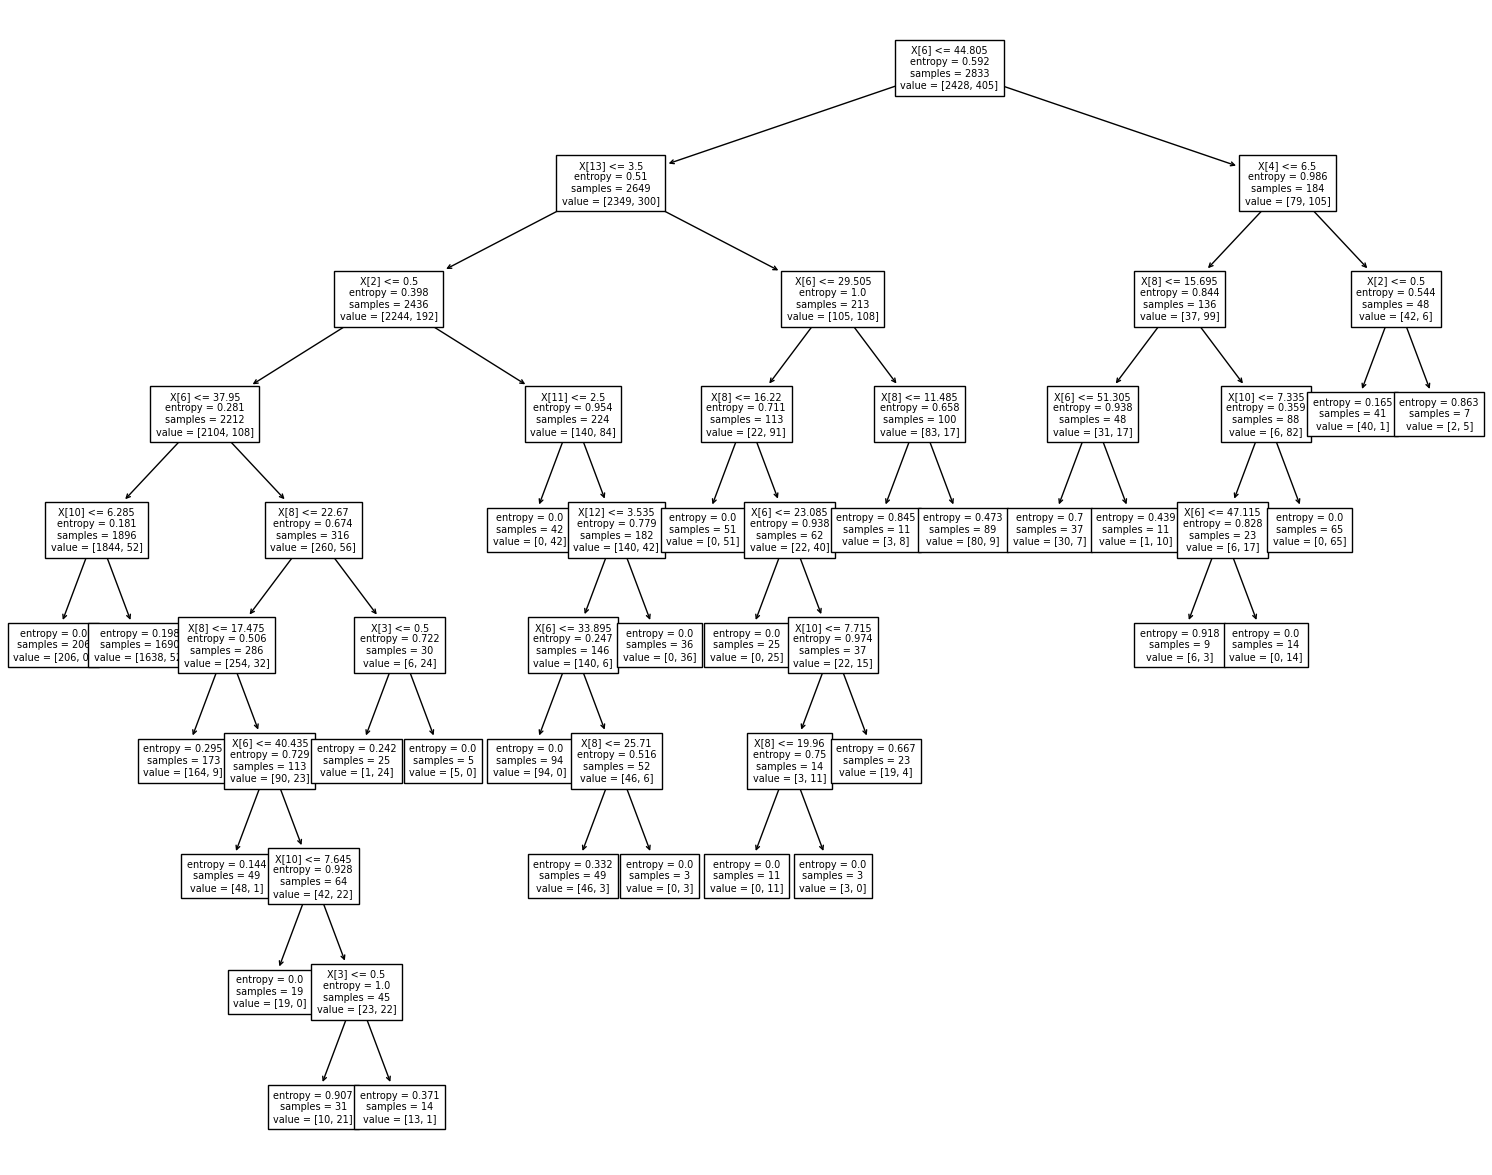

In [218]:
fig = plt.figure(figsize=(19, 15))
fig = tree.plot_tree(DecisionTreeClassifier(
    **{
        'criterion': 'entropy',
        'max_depth': None,
        'max_features': None,
        'max_leaf_nodes': 28,
        'min_samples_leaf': 2}
).fit(X_train, y_train), fontsize=7)
plt.show()

### 1.2 Классификация ириса из датасет iris. 

Предскажите вид ириса по его параметрам.

In [219]:
iris = sns.load_dataset('iris')

In [220]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [221]:
target = "species"

In [222]:
y = iris[target]
X = iris[iris.columns[~iris.columns.isin([target])]]

In [223]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=True, shuffle=True)

In [227]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((127, 4), (127,), (23, 4), (23,))

In [228]:
DT_classifier = DecisionTreeClassifier(random_state=42) # with default parameters

In [229]:
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [230]:
DT_classifier.score(X_test, y_test)

0.9565217391304348

In [231]:
cross_val_score(DT_classifier, X, y, cv=5).mean()

0.9533333333333334

In [232]:
params_max_depth = {
    "criterion": ["entropy"],
    "max_depth": range(1, 20),
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2],
}

In [233]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_depth, n_jobs=6, cv=5, verbose=False)

In [234]:
model = gridsearch_tree.fit(X_train, y_train)

In [235]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [236]:
params_max_features = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": range(5),
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2]
}

In [237]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_features, n_jobs=6, cv=5, verbose=False)

In [238]:
model = gridsearch_tree.fit(X_train, y_train)

In [239]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [240]:
params_max_leaf_nodes = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": range(1, 30),
    "min_samples_leaf": [2]
}

In [241]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_leaf_nodes, n_jobs=6, cv=5, verbose=False)

In [242]:
model = gridsearch_tree.fit(X_train, y_train)

In [243]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 4,
 'min_samples_leaf': 2}

In [244]:
params_min_samples_leaf = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": range(2, 20)
}

In [245]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_min_samples_leaf, n_jobs=6, cv=5, verbose=False)

In [246]:
model = gridsearch_tree.fit(X_train, y_train)

In [247]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [248]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": range(1, 6),
    "max_features": range(1, 4),
    "max_leaf_nodes": range(3, 6),
    "min_samples_leaf": range(1, 6)
}

In [249]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params, n_jobs=6, cv=5, verbose=False)

In [250]:
model = gridsearch_tree.fit(X_train, y_train)

In [251]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 2,
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1}

In [252]:
model.best_score_

0.9603076923076923

In [253]:
model.score(X_test, y_test)

0.9565217391304348

    Results for default DecisionTreeClassifier = 0.9565, with CV = 0.9533
    With GridSearch we get better result = 0.9565

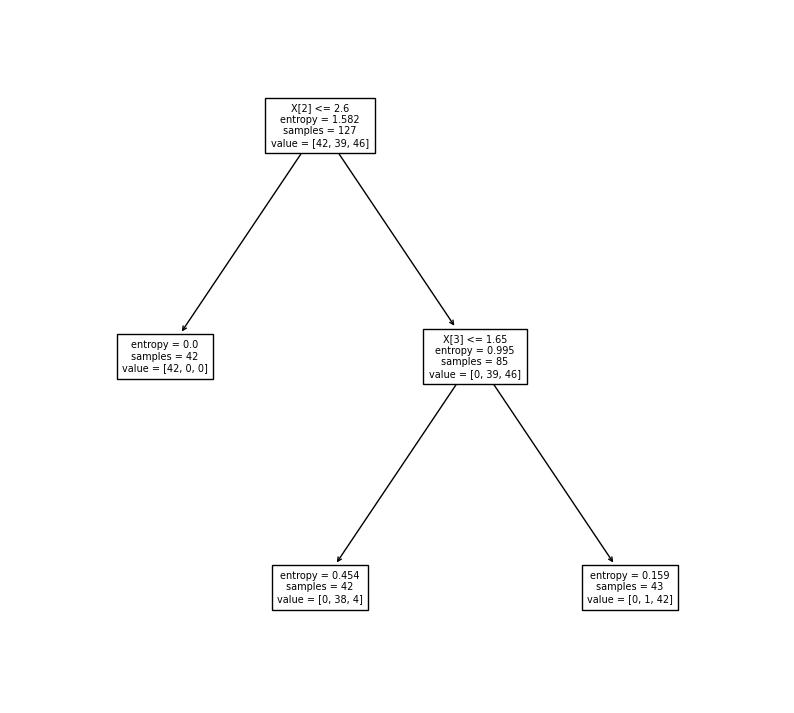

In [254]:
fig = plt.figure(figsize=(10, 9))
fig = tree.plot_tree(model.best_estimator_, fontsize=7)
plt.show()

### 1.3 Предсказание диабета у пациентов.

Используйте данные из файла diabetes.csv для предсказания исхода для пациентов. Столбец "outcome". Предварительно изучите и подготовьте данные. 

In [255]:
df_diabetes = pd.read_csv("diabetes.csv")

In [259]:
target = "Outcome"

In [260]:
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [272]:
true_label = "diabetes"
false_label = "no diabetes"

In [262]:
y = df_diabetes[target]
X = df_diabetes[df_diabetes.columns[~df_diabetes.columns.isin([target])]]

In [263]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Quantitive variables stats

In [264]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [265]:
X[X.Pregnancies == max(X.Pregnancies)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
159,17,163,72,41,114,40.9,0.817,47


In [266]:
X.shape

(768, 8)

#### Stats for target variable

In [273]:
pd.DataFrame({
    true_label: [sum(y == 1), sum(y == 1) / len(y)],
    false_label: [sum(y == 0), sum(y == 0) / len(y)],
}, index = ['count', 'percent'])

,diabetes,no diabetes
count,268.000000,500.000000
percent,0.348958,0.651042


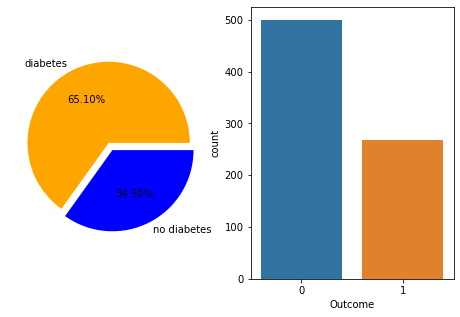

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

y.value_counts().plot.pie(explode=[0, 0.1], 
                           autopct='%1.2f%%', ax=ax[0], 
                           labels=[true_label, false_label],
                           colors=['orange', 'blue'])
ax[0].set_ylabel('')
sns.countplot(target, data=pd.DataFrame(y.replace({False: false_label, True: true_label})), ax=ax[1])
plt.show()

#### Quantitive vs Categorical

In [275]:
X.columns[0]

'Pregnancies'

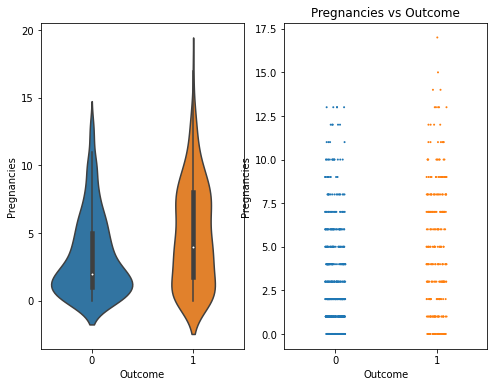

In [278]:
violin_strip_plot(X.columns[0], X, y)

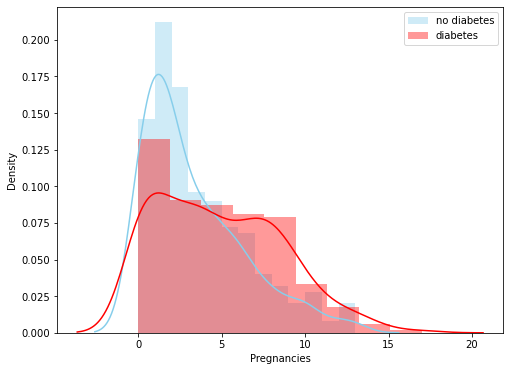

In [282]:
histogram(X.columns[0], X, y)

In [283]:
descriptive_stats(X.columns[0], X, y)

,0,1
count,500.000000,268.000000
mean,3.298000,4.865672
std,3.017185,3.741239
min,0.000000,0.000000
25%,1.000000,1.750000
50%,2.000000,4.000000
75%,5.000000,8.000000
max,13.000000,17.000000


In [284]:
count_outliers(X.columns[0], X, y)

,0,1
amount,10.00,0.0
percent,0.02,0.0


In [285]:
X.columns[1]

'Glucose'

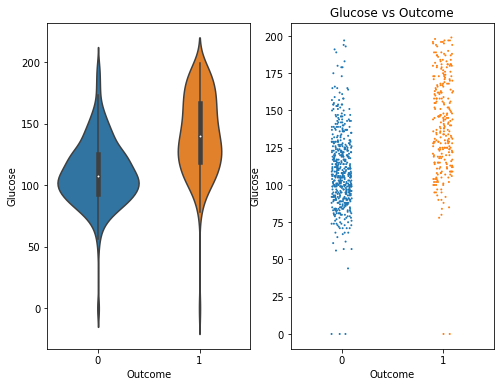

In [286]:
violin_strip_plot(X.columns[1], X, y)

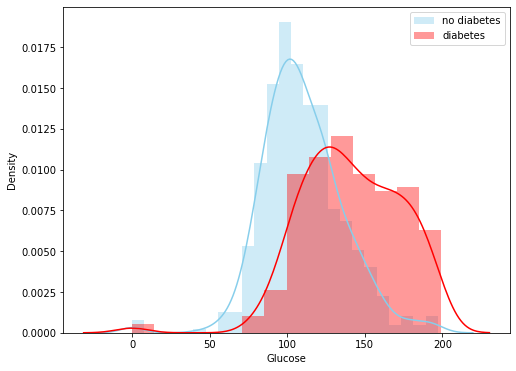

In [287]:
histogram(X.columns[1], X, y)

In [288]:
descriptive_stats(X.columns[1], X, y)

,0,1
count,500.0000,268.000000
mean,109.9800,141.257463
std,26.1412,31.939622
min,0.0000,0.000000
25%,93.0000,119.000000
50%,107.0000,140.000000
75%,125.0000,167.000000
max,197.0000,199.000000


In [289]:
count_outliers(X.columns[1], X, y)

,0,1
amount,14.000,2.000000
percent,0.028,0.007463


In [290]:
X.columns[2]

'BloodPressure'

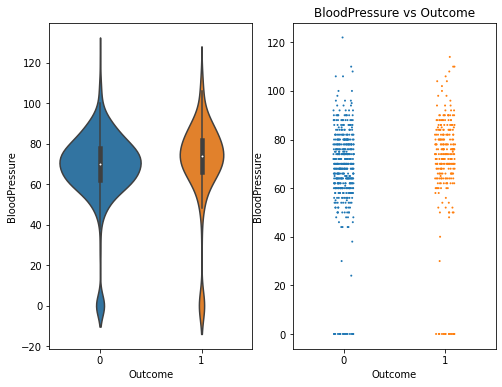

In [291]:
violin_strip_plot(X.columns[2], X, y)

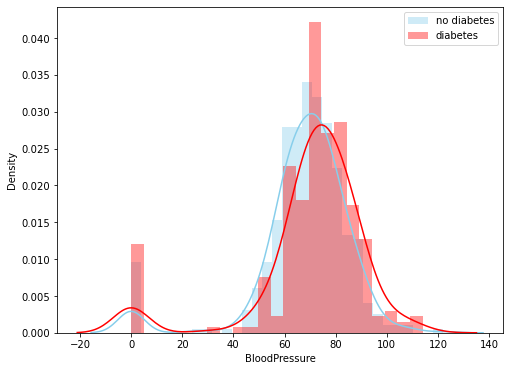

In [292]:
histogram(X.columns[2], X, y)

In [293]:
descriptive_stats(X.columns[2], X, y)

,0,1
count,500.000000,268.000000
mean,68.184000,70.824627
std,18.063075,21.491812
min,0.000000,0.000000
25%,62.000000,66.000000
50%,70.000000,74.000000
75%,78.000000,82.000000
max,122.000000,114.000000


In [294]:
count_outliers(X.columns[2], X, y)

,0,1
amount,26.000,22.00000
percent,0.052,0.08209


In [295]:
X.columns[3]

'SkinThickness'

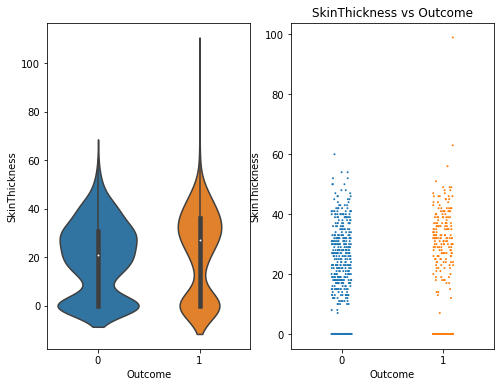

In [296]:
violin_strip_plot(X.columns[3], X, y)

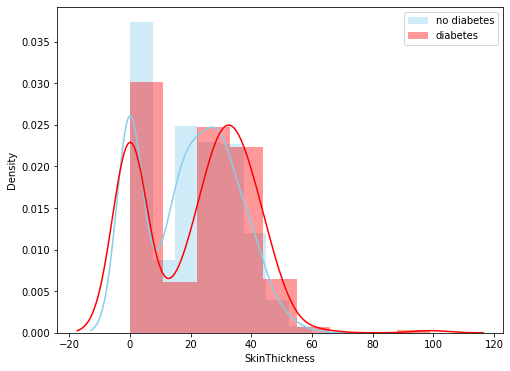

In [297]:
histogram(X.columns[3], X, y)

In [298]:
descriptive_stats(X.columns[3], X, y)

,0,1
count,500.000000,268.000000
mean,19.664000,22.164179
std,14.889947,17.679711
min,0.000000,0.000000
25%,0.000000,0.000000
50%,21.000000,27.000000
75%,31.000000,36.000000
max,60.000000,99.000000


In [299]:
count_outliers(X.columns[3], X, y)

,0,1
amount,0.0,1.000000
percent,0.0,0.003731


In [300]:
X.columns[4]

'Insulin'

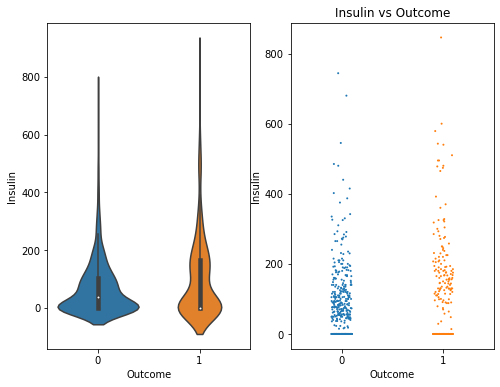

In [301]:
violin_strip_plot(X.columns[4], X, y)

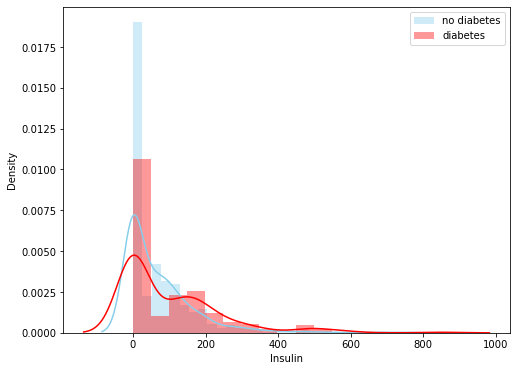

In [302]:
histogram(X.columns[4], X, y)

In [303]:
descriptive_stats(X.columns[4], X, y)

,0,1
count,500.000000,268.000000
mean,68.792000,100.335821
std,98.865289,138.689125
min,0.000000,0.000000
25%,0.000000,0.000000
50%,39.000000,0.000000
75%,105.000000,167.250000
max,744.000000,846.000000


In [304]:
count_outliers(X.columns[4], X, y)

,0,1
amount,26.000,12.000000
percent,0.052,0.044776


In [305]:
X.columns[5]

'BMI'

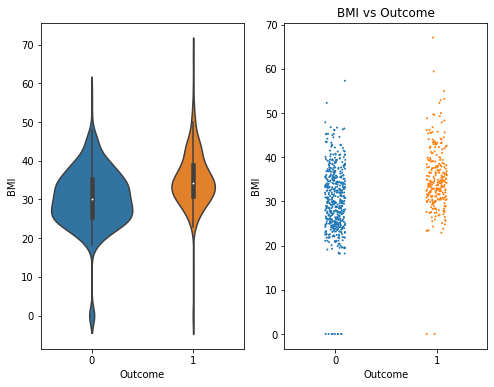

In [306]:
violin_strip_plot(X.columns[5], X, y)

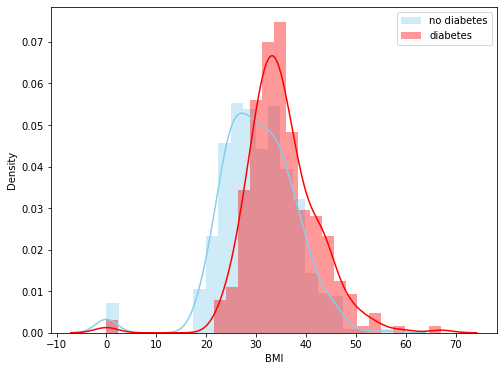

In [307]:
histogram(X.columns[5], X, y)

In [308]:
descriptive_stats(X.columns[5], X, y)

,0,1
count,500.000000,268.000000
mean,30.304200,35.142537
std,7.689855,7.262967
min,0.000000,0.000000
25%,25.400000,30.800000
50%,30.050000,34.250000
75%,35.300000,38.775000
max,57.300000,67.100000


In [309]:
count_outliers(X.columns[5], X, y)

,0,1
amount,11.000,8.000000
percent,0.022,0.029851


In [310]:
X.columns[6]

'DiabetesPedigreeFunction'

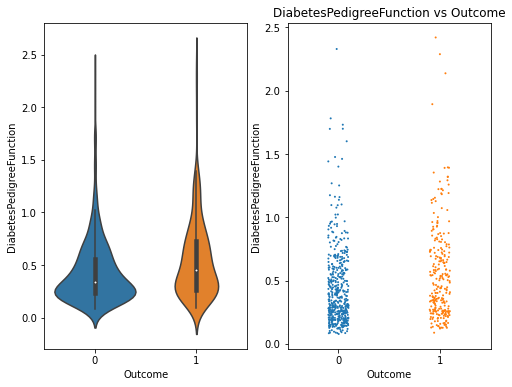

In [311]:
violin_strip_plot(X.columns[6], X, y)

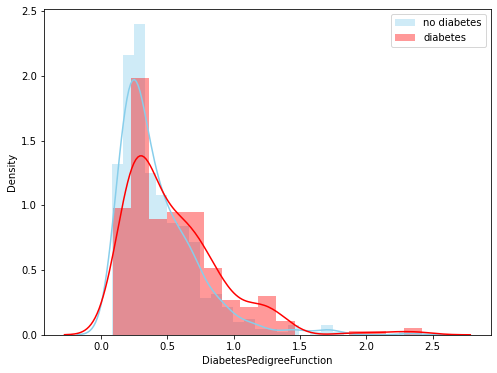

In [312]:
histogram(X.columns[6], X, y)

In [313]:
descriptive_stats(X.columns[6], X, y)

,0,1
count,500.000000,268.000000
mean,0.429734,0.550500
std,0.299085,0.372354
min,0.078000,0.088000
25%,0.229750,0.262500
50%,0.336000,0.449000
75%,0.561750,0.728000
max,2.329000,2.420000


In [314]:
count_outliers(X.columns[6], X, y)

,0,1
amount,20.00,4.000000
percent,0.04,0.014925


In [316]:
X.columns[7]

'Age'

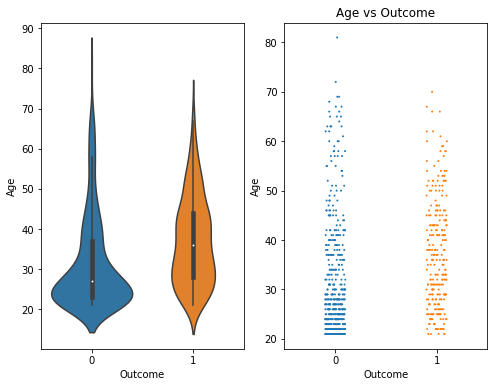

In [317]:
violin_strip_plot(X.columns[7], X, y)

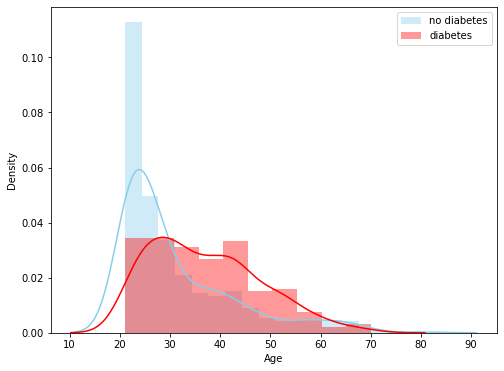

In [318]:
histogram(X.columns[7], X, y)

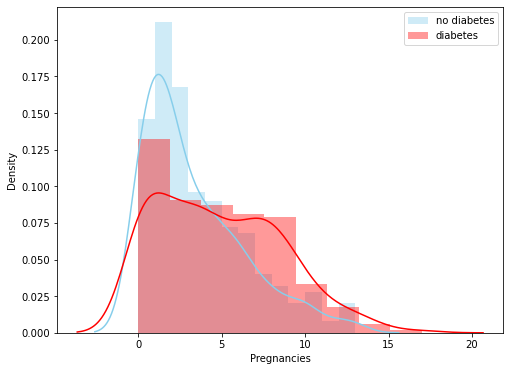

In [323]:
histogram(X.columns[0], X, y)

In [319]:
descriptive_stats(X.columns[7], X, y)

,0,1
count,500.000000,268.000000
mean,31.190000,37.067164
std,11.667655,10.968254
min,21.000000,21.000000
25%,23.000000,28.000000
50%,27.000000,36.000000
75%,37.000000,44.000000
max,81.000000,70.000000


In [320]:
count_outliers(X.columns[7], X, y)

,0,1
amount,24.000,1.000000
percent,0.048,0.003731


In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=True, shuffle=True)

In [327]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((652, 8), (652,), (116, 8), (116,))

In [328]:
DT_classifier = DecisionTreeClassifier(random_state=42) # with default parameters

In [329]:
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [330]:
DT_classifier.score(X_test, y_test)

0.6724137931034483

In [331]:
cross_val_score(DT_classifier, X, y, cv=5).mean()

0.7163059163059163

In [332]:
params_max_depth = {
    "criterion": ["entropy"],
    "max_depth": range(1, 20),
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2],
}

In [333]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_depth, n_jobs=6, cv=5, verbose=False)

In [334]:
model = gridsearch_tree.fit(X_train, y_train)

In [335]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [336]:
params_max_features = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": range(8),
    "max_leaf_nodes": [None],
    "min_samples_leaf": [2]
}

In [337]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_features, n_jobs=6, cv=5, verbose=False)

In [338]:
model = gridsearch_tree.fit(X_train, y_train)

In [339]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2}

In [340]:
params_max_leaf_nodes = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": range(1, 30),
    "min_samples_leaf": [2]
}

In [341]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_max_leaf_nodes, n_jobs=6, cv=5, verbose=False)

In [342]:
model = gridsearch_tree.fit(X_train, y_train)

In [343]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 4,
 'min_samples_leaf': 2}

In [344]:
params_min_samples_leaf = {
    "criterion": ["entropy"],
    "max_depth": [None],
    "max_features": [None],
    "max_leaf_nodes": [None],
    "min_samples_leaf": range(2, 20)
}

In [345]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params_min_samples_leaf, n_jobs=6, cv=5, verbose=False)

In [346]:
model = gridsearch_tree.fit(X_train, y_train)

In [347]:
model.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 19}

In [348]:
params = {
    "criterion": ["entropy", "gini"],
    "max_depth": range(1, 4),
    "max_features": range(2, 5),
    "max_leaf_nodes": range(3, 6),
    "min_samples_leaf": range(15, 25, 2)
}

In [349]:
gridsearch_tree = GridSearchCV(DT_classifier, param_grid=params, n_jobs=6, cv=5, verbose=False)

In [350]:
model = gridsearch_tree.fit(X_train, y_train)

In [351]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 3,
 'max_leaf_nodes': 4,
 'min_samples_leaf': 15}

In [352]:
model.best_score_

0.7330593071051087

In [353]:
model.score(X_test, y_test)

0.7327586206896551

    Results for default DecisionTreeClassifier = 0.67, with CV = 0.716
    With GridSearch we get better result = 0.732

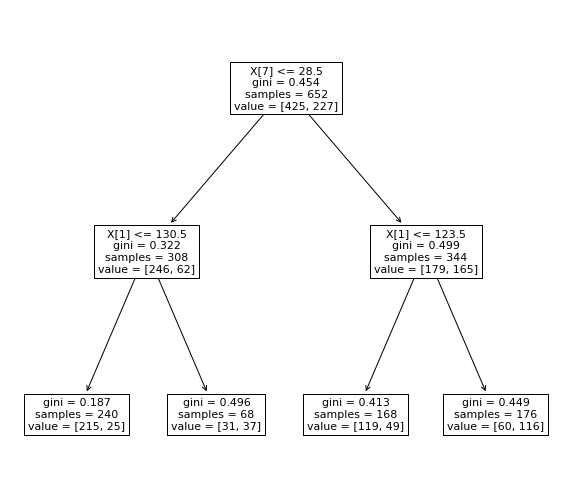

In [355]:
fig = plt.figure(figsize=(10, 9))
fig = tree.plot_tree(model.best_estimator_, fontsize=11)
plt.show()

## Задание 2. 

Используя данные из файла IceCreamData.csv предскажите количественное значение дохода от продажи мороженного в зависимости от температуры воздуха.  Используйте регрессию на основе дерева принятия решений. Решите эту же задачу, испотзуя полиномиальную регрессию. Сравните качество моделей.

In [356]:
df_ice_cream_data = pd.read_csv("IceCreamData.csv")

In [357]:
df_ice_cream_data.head()

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194


In [360]:
target = "Revenue"

In [358]:
from sklearn.tree import DecisionTreeRegressor

In [359]:
tree_reg = DecisionTreeRegressor()

In [363]:
y = df_ice_cream_data["Revenue"]
X = df_ice_cream_data[df_ice_cream_data.columns[~df_ice_cream_data.columns.isin([target])]]

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=True, shuffle=True)

In [365]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [367]:
tree_reg.score(X_train, y_train)

1.0

In [368]:
tree_reg.score(X_test, y_test)

0.96410826717265

In [371]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [388]:
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                   ('linear', LinearRegression(fit_intercept=True))])

In [389]:
model = model.fit(X_train, y_train)

In [390]:
model.score(X_test, y_test)

0.9755524059846075

In [384]:
PolynomialFeatures(degree=3).fit_transform(X_train)

array([[1.00000000e+00, 3.20043651e+01, 1.02427938e+03, 3.27814113e+04],
       [1.00000000e+00, 1.71327954e+01, 2.93532678e+02, 5.02903530e+03],
       [1.00000000e+00, 1.81592168e+01, 3.29757154e+02, 5.98813164e+03],
       ...,
       [1.00000000e+00, 7.33544501e+00, 5.38087535e+01, 3.94711152e+02],
       [1.00000000e+00, 3.61165615e+01, 1.30440601e+03, 4.71106599e+04],
       [1.00000000e+00, 1.75170740e+01, 3.06847880e+02, 5.37507702e+03]])

In [391]:
tree_reg.fit(PolynomialFeatures(degree=5).fit_transform(X_train), y_train)

DecisionTreeRegressor()

In [392]:
tree_reg.score(PolynomialFeatures(degree=5).fit_transform(X_train), y_train)

1.0

In [394]:
tree_reg.score(PolynomialFeatures(degree=5).fit(X_train).transform(X_test), y_test)

0.96410826717265

    Polynomial regression shows the best results. I tried to use ponimonial data on DesicionTree, but it doesn't even effect the results. 

## Ссылки

Классификация.  https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial

Документация.   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


Регрессия.  https://www.aionlinecourse.com/tutorial/machine-learning/decision-tree-intuition